# Distribution of the Data - Comparison to the dataset measured values
## AlphaSeq
Let's take a look at how this was done for the Alphaseq dataset first, then do this to our DMS data:

# na free entries: 352139
# unique entries: 87807
# entries w/ rmse calculated: 352139
# dedup entries: 87807


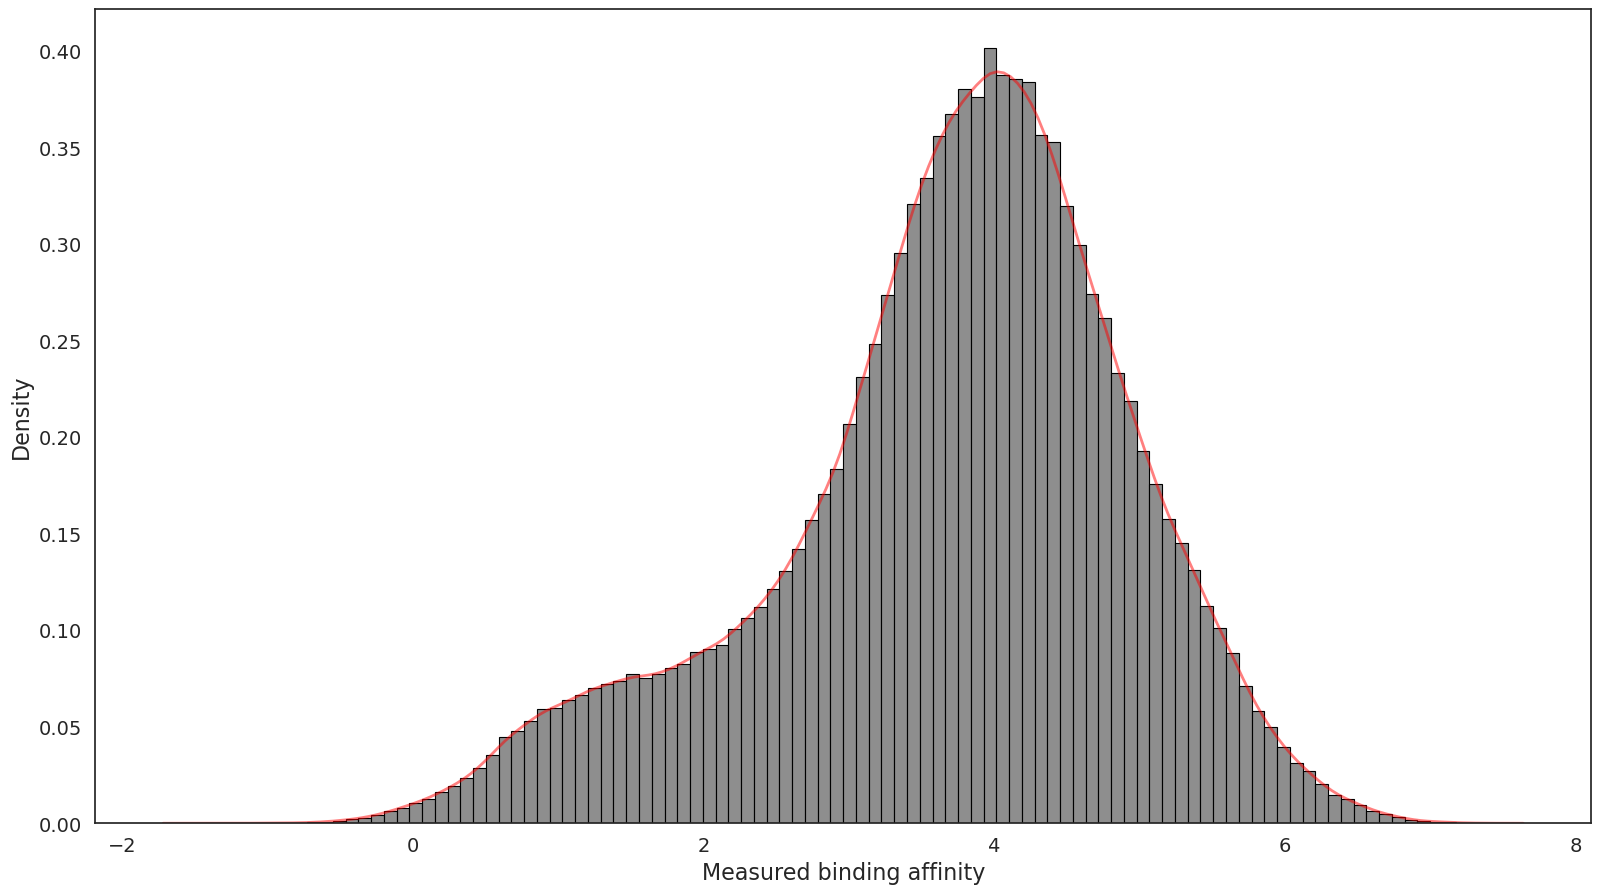

# entries with single seqs dropped 73741


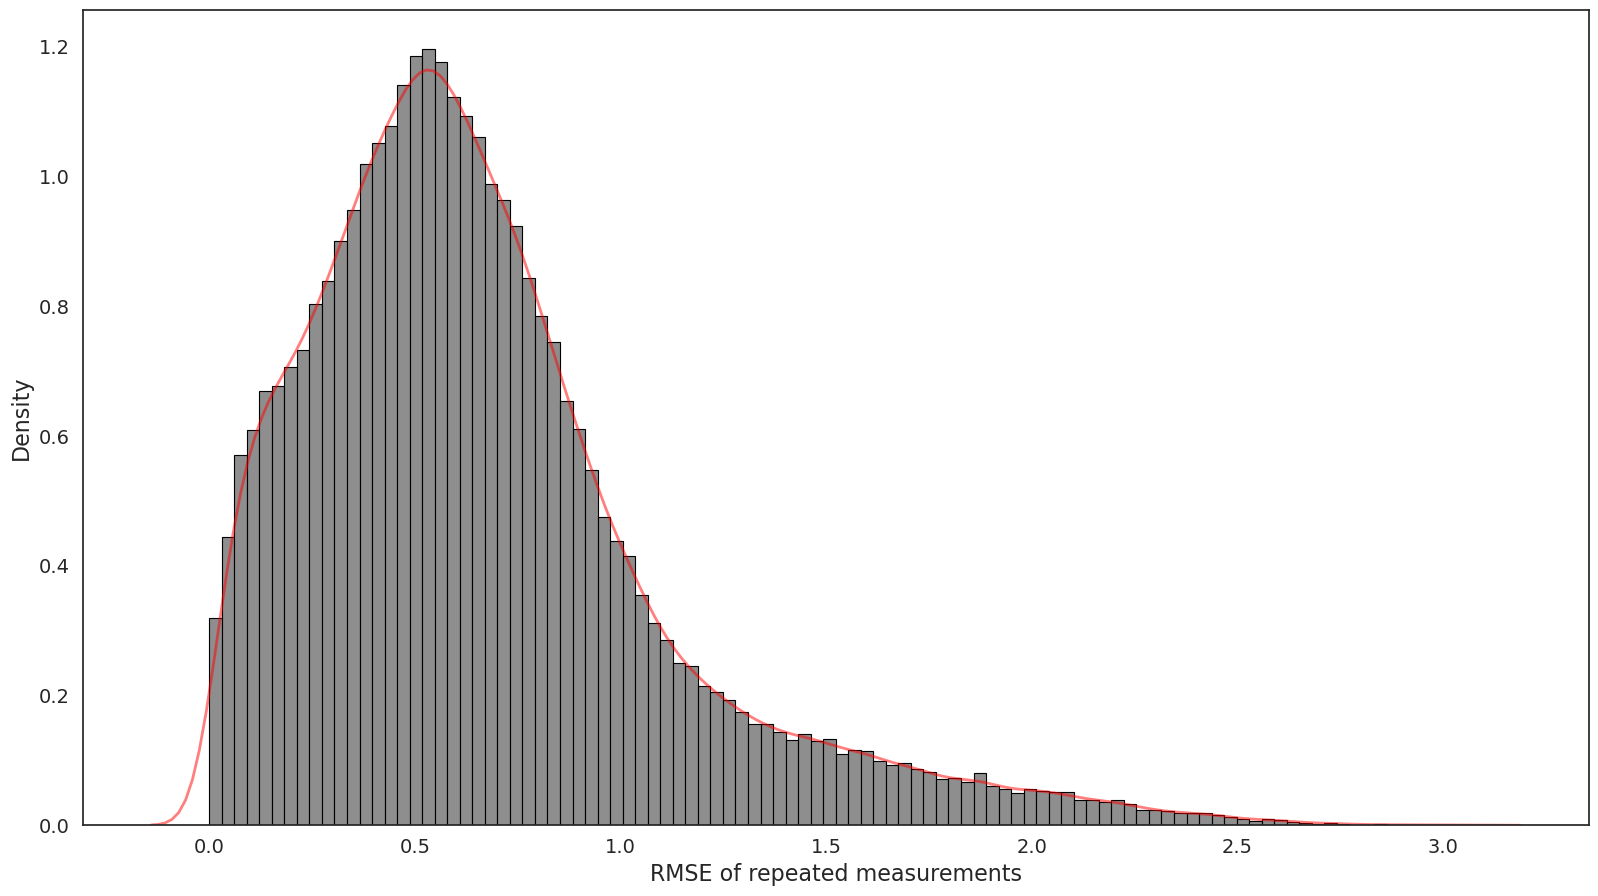

In [157]:
import os
import math  
import sklearn.metrics 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_value_distribution(df, value_col:str, x_label:str, save_as:str=None):
    """ 
    Plots the given value distribution. 
    """
    sns.set_theme()
    sns.set_context('talk')
    sns.set(style='white')
    plt.figure(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'

    # Create histogram and kde plot
    sns.histplot(df[value_col], kde=False, stat='density', bins=100, color='dimgrey', edgecolor='black')
    sns.kdeplot(df[value_col], color='red', linewidth=2, alpha=0.5)

    plt.tight_layout()
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.show()

alpha_seq_data = pd.read_csv('/data/spike_ml/Spike_NLP_valerie/Spike_NLP/data/alphaseq/MITLL_AAlphaBio_Ab_Binding_dataset.csv')
alpha_seq_data = alpha_seq_data[['POI','Sequence', 'Pred_affinity']]

# = Remove NaN values =
na_free = alpha_seq_data.dropna()
print('# na free entries:', len(na_free)) 

# = Check for duplicate sequences by identifying unique sequences =
sequence_set = set()
for seq in na_free['Sequence']:
    sequence_set.add(seq)
print('# unique entries:', len(sequence_set)) # 87807 unique sequences

# = Calculate RMSE =
na_free = na_free.copy()  
# Group by POI and calculate mean for each group
na_free['Mean_affinity'] = na_free.groupby('POI')['Pred_affinity'].transform('mean')
# Calculate the difference squared
na_free['differencesquared'] = (na_free['Pred_affinity'] - na_free['Mean_affinity']) ** 2
# Calculate the MSE for each group
na_free['mse'] = na_free.groupby('POI')['differencesquared'].transform('mean')
# Calculate the RMSE
na_free['rmse'] = np.sqrt(na_free['mse'])
print('# entries w/ rmse calculated:', len(na_free))

# = Drop replicates using sequences =
dedup_alpha_seq = na_free.drop_duplicates(subset='Sequence', keep='first')
print('# dedup entries:', len(dedup_alpha_seq)) # 87807
plot_value_distribution(alpha_seq_data, "Pred_affinity", "Measured binding affinity")

# = Drop single sequences =
dups_only = dedup_alpha_seq[dedup_alpha_seq['rmse'] != 0.0]
print('# entries with single seqs dropped', len(dups_only))
plot_value_distribution(dups_only, "rmse", "RMSE of repeated measurements")

---
## Older DMS Data
Let's take a look at some distributions of the data these are similar and generated in the same way to the **Supplementary Figure 5A and 5B** (the above), but are not currently in the manuscript supplementary section. 

### Binding

In [158]:
def label_to_seq_old(row) -> str:
    """ Generate sequence based on reference sequence and aa_substitutions. """
    aa_substitutions, target = row['aa_substitutions'], row['target']
    refseq = list('NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST')
    seq = refseq.copy()
    p = '([0-9]+)'
    
    if '_' in aa_substitutions:
        for mutcode in aa_substitutions.split('_'):
            [ori, pos, mut] = re.split(p, mutcode)
            pos = int(pos)-1    # use 0-based counting
            #assert refseq[pos].upper() == ori, f"At {pos}: {refseq[pos]} != {ori}"
            if refseq[pos].upper() != ori: print(f"{target}, At {pos}: {refseq[pos]} != {ori}")
            seq[pos] = mut.upper()
        seq = ''.join(seq)
        return seq

    if aa_substitutions=='': return ''.join(seq)

    [ori, pos, mut] = re.split(p, aa_substitutions)
    pos = int(pos)-1    # use 0-based counting
    #assert refseq[pos].upper() == ori, f"At {pos}: {refseq[pos]} != {ori}"
    if refseq[pos].upper() != ori: print(f"{target}, At {pos}: {refseq[pos]} != {ori}")
    seq[pos] = mut.upper()
    seq = ''.join(seq)    
    return seq

In [159]:
import os
import re
import numpy as np
import pandas as pd

binding_df = pd.read_csv('/data/spike_ml/Spike_NLP_kaetlyn/data/dms_binding_Kds.csv', sep=',', header=0)
row_count = len(binding_df)

# Remove rows where specified column is NA
binding_df = binding_df.dropna(subset=['log10Ka']).reset_index(drop=True)
print(f"Number of data points with na: {row_count-len(binding_df)}")
print(f"Number of data points left: {len(binding_df)}\n")

# Filter out variant classes that are not nonsynonymous
nonsynonymous_df = binding_df[binding_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
print(f"Number of datapoints after removal of nonsynonymous variant classes: {len(nonsynonymous_df)}\n")

# Add '_' to aa_substitutions column
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['aa_substitutions'] = nonsynonymous_df['aa_substitutions'].replace(' ', '_', regex=True)
# Apply mutation to reference sequence
nonsynonymous_df['sequence'] = nonsynonymous_df.apply(label_to_seq_old, axis=1)

# Create a new column 'label' using 'target' and 'aa_substitutions' columns
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['label'] = nonsynonymous_df['target'] + '-' + nonsynonymous_df['aa_substitutions']
print(f"{nonsynonymous_df['label'].value_counts()}\n")

# Filter to only the columns we want 
nonsynonymous_df = nonsynonymous_df[['label','target', 'sequence', 'log10Ka']].copy()

# Group by label and calculate mean_log10Ka, mse, and rmse for each group
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['mean_log10Ka'] = nonsynonymous_df.groupby('label')['log10Ka'].transform('mean')
nonsynonymous_df['difference_squared_binding'] = (nonsynonymous_df['log10Ka'] - nonsynonymous_df['mean_log10Ka']) ** 2
nonsynonymous_df['mse_binding'] = nonsynonymous_df.groupby('label')['difference_squared_binding'].transform('mean')
nonsynonymous_df['rmse_binding'] = np.sqrt(nonsynonymous_df['mse_binding'])
print('Number entries w/ rmse calculated:', len(nonsynonymous_df))

binding_df = nonsynonymous_df.copy()
binding_df

Number of data points with na: 48644
Number of data points left: 146437

Number of datapoints after removal of nonsynonymous variant classes: 136204

label
SARS-CoV-2-C61S                                49
SARS-CoV-2-D90S                                47
SARS-CoV-2-Y119L                               44
SARS-CoV-2-G86S                                42
SARS-CoV-2-D90L                                41
                                               ..
SARS-CoV-2-Q84L_T100L_L131H_V153S               1
SARS-CoV-2-D68A_G117M                           1
SARS-CoV-2-Y35L_T201R                           1
SARS-CoV-2-N58T_A67H_F99Y_C102W_E141H_T201R     1
SARS-CoV-2-N1I_Q84I_N130L                       1
Name: count, Length: 105525, dtype: int64

Number entries w/ rmse calculated: 136204


,label,target,sequence,log10Ka,mean_log10Ka,difference_squared_binding,mse_binding,rmse_binding
0,SARS-CoV-2-A22C_R127G_E141D_L188V,SARS-CoV-2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,8.72,8.720000,0.000000,0.000000,0.000000
1,SARS-CoV-2-N13F,SARS-CoV-2,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,10.35,10.358182,0.000067,0.002415,0.049141
2,SARS-CoV-2-V71K_P149L_N157T,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,6.00,6.000000,0.000000,0.000000,0.000000
3,SARS-CoV-2-A18V_T148S_H189Y,SARS-CoV-2,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,10.15,10.135000,0.000225,0.000225,0.015000
4,SARS-CoV-2-T63D_A89N,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,9.61,9.610000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
146431,SARS-CoV-2-Y66L_G174N,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,10.59,10.590000,0.000000,0.000000,0.000000
146432,SARS-CoV-2-Y165S,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.18,8.367857,0.035290,0.021103,0.145267
146433,SARS-CoV-2-G83V_D98L,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,9.46,9.460000,0.000000,0.000000,0.000000
146434,SARS-CoV-2-V71H_S147Q,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,6.00,6.000000,0.000000,0.000000,0.000000


I will be plotting the `mean_log10Ka` rather than log10Ka. This is because in my cleaned data I replace all log10Ka values of duplicate label entries with the mean_log10Ka value, and then I delete the duplicates. This is to standardize the duplicate values. Same for expression.

Number of dedup entries: 105525


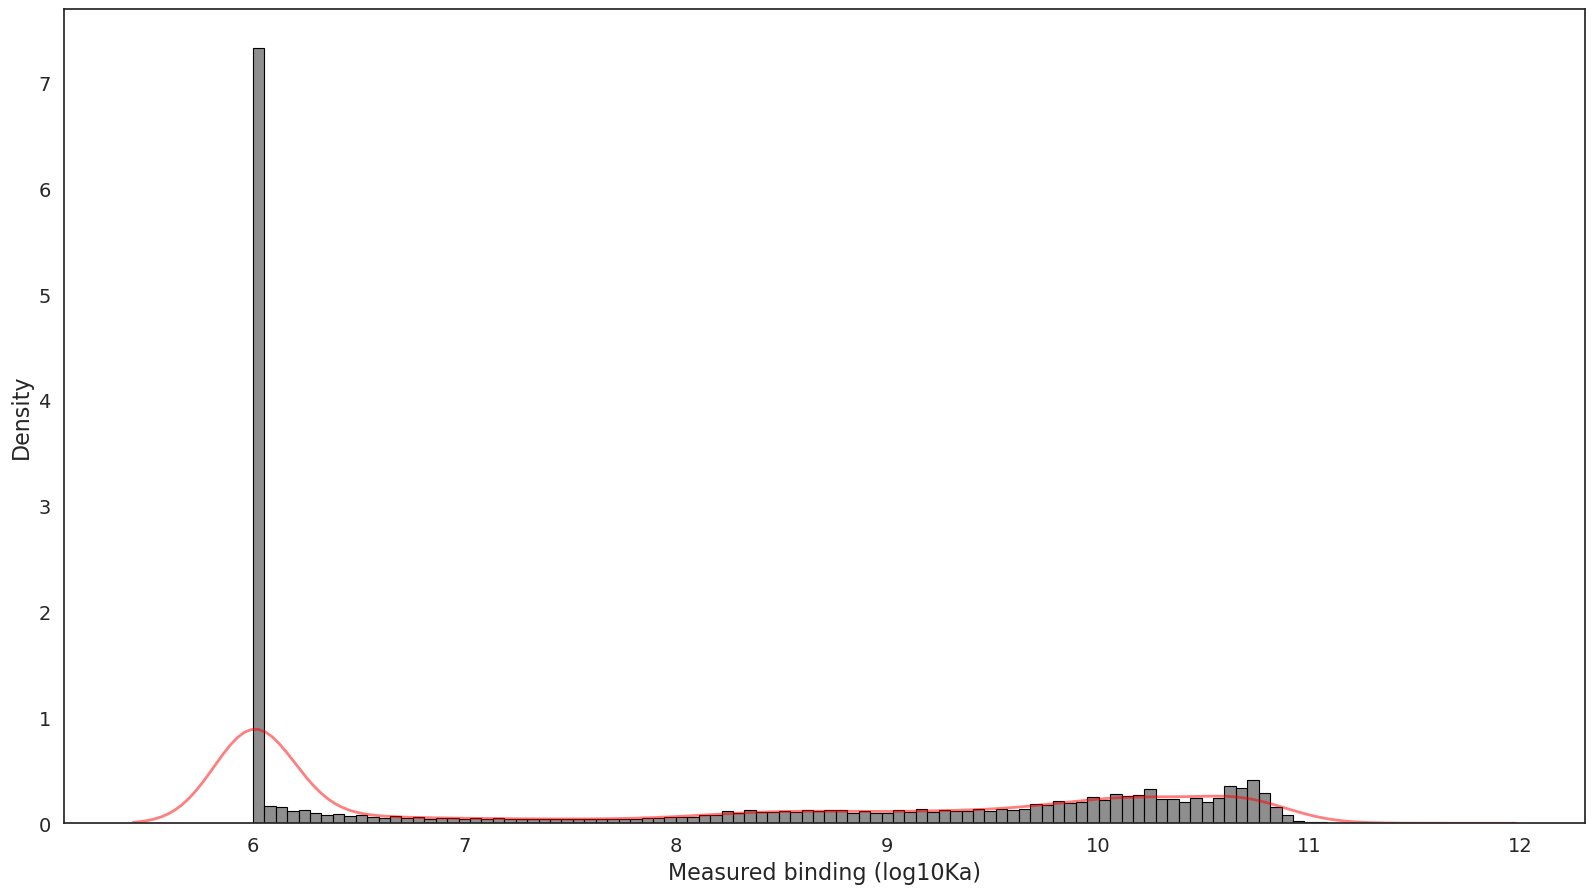

Number of dedup entries that had dups: 7688


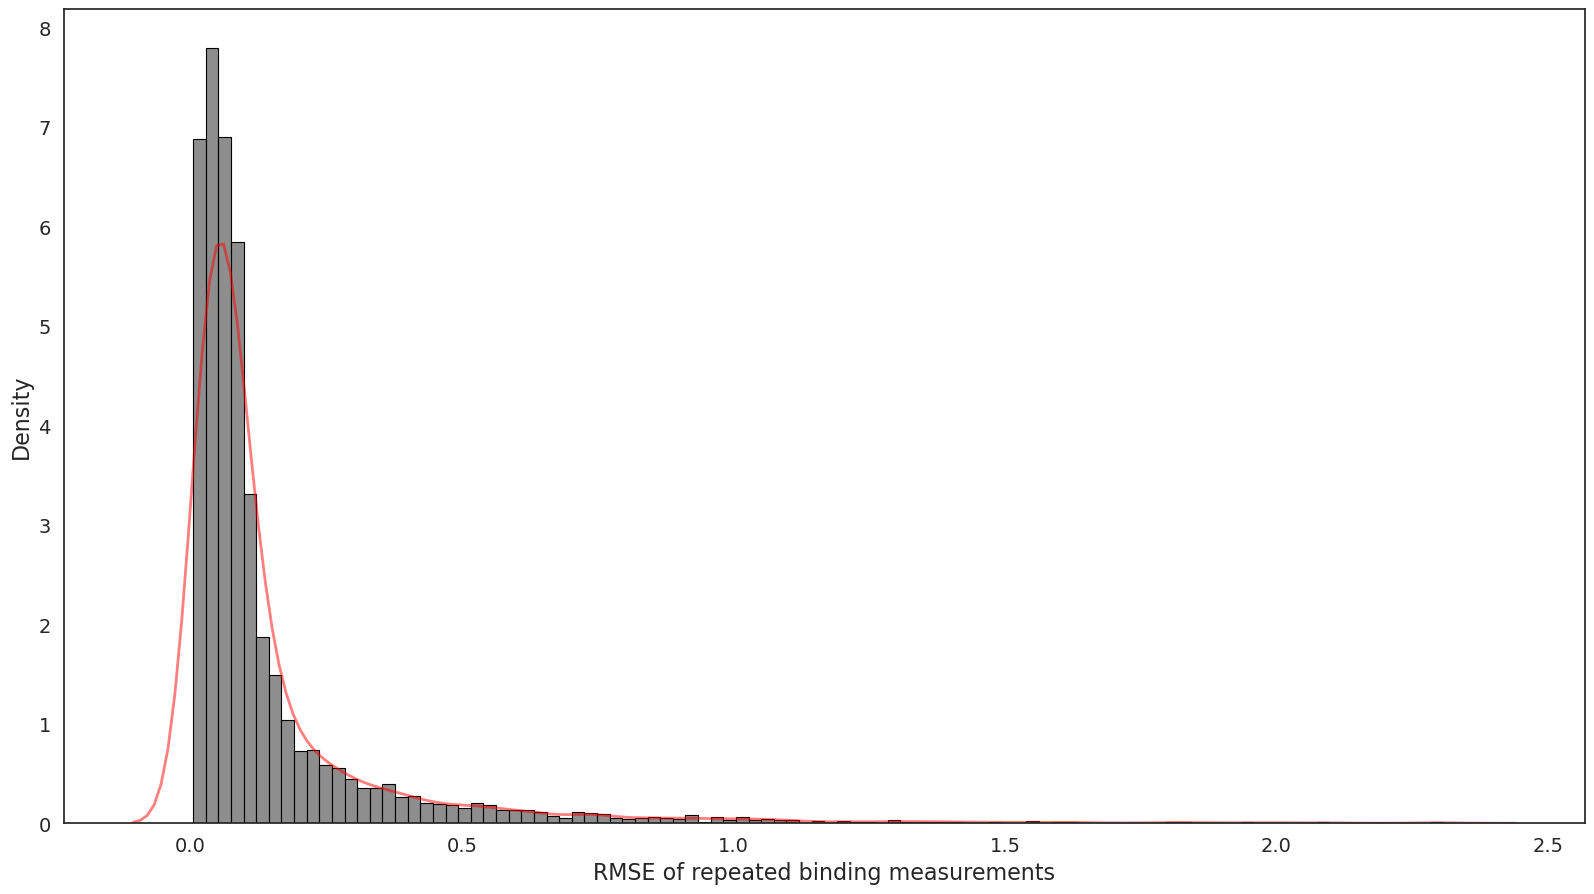

In [160]:
# Drop replicates using sequences
dedup_binding_df = binding_df.drop_duplicates(subset='label', keep='first')
print('Number of dedup entries:', len(dedup_binding_df)) 
plot_value_distribution(dedup_binding_df, "mean_log10Ka", "Measured binding (log10Ka)")

# Drop single sequences 
dups_only_binding_df = dedup_binding_df[dedup_binding_df['rmse_binding'] != 0.0]
print('Number of dedup entries that had dups:', len(dups_only_binding_df))
plot_value_distribution(dups_only_binding_df, "rmse_binding", "RMSE of repeated binding measurements")

### Expression

In [161]:
expression_df = pd.read_csv('/data/spike_ml/Spike_NLP_kaetlyn/data/dms_expression_meanFs.csv', sep=',', header=0)
row_count = len(expression_df)

# Remove rows where specified column is NA
expression_df = expression_df.dropna(subset=['ML_meanF']).reset_index(drop=True)
print(f"Number of data points with na: {row_count-len(expression_df)}")
print(f"Number of data points left: {len(expression_df)}\n")

# Filter out variant classes that are not nonsynonymous
nonsynonymous_df = expression_df[expression_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
print(f"Number of datapoints after removal of nonsynonymous variant classes: {len(nonsynonymous_df)}\n")

# Add '_' to aa_substitutions column
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['aa_substitutions'] = nonsynonymous_df['aa_substitutions'].replace(' ', '_', regex=True)
# Apply mutation to reference sequence
nonsynonymous_df['sequence'] = nonsynonymous_df.apply(label_to_seq_old, axis=1)

# Create a new column 'label' using 'target' and 'aa_substitutions' columns
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['label'] = nonsynonymous_df['target'] + '-' + nonsynonymous_df['aa_substitutions']
print(f"{nonsynonymous_df['label'].value_counts()}\n")

# Filter to only the columns we want 
nonsynonymous_df = nonsynonymous_df[['label','target', 'sequence', 'ML_meanF']].copy()

# Group by label and calculate mean_ML_meanF, mse, and rmse for each group
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['mean_ML_meanF'] = nonsynonymous_df.groupby('label')['ML_meanF'].transform('mean')
nonsynonymous_df['difference_squared_expression'] = (nonsynonymous_df['ML_meanF'] - nonsynonymous_df['mean_ML_meanF']) ** 2
nonsynonymous_df['mse_expression'] = nonsynonymous_df.groupby('label')['difference_squared_expression'].transform('mean')
nonsynonymous_df['rmse_expression'] = np.sqrt(nonsynonymous_df['mse_expression'])
print('Number entries w/ rmse calculated:', len(nonsynonymous_df))

expression_df = nonsynonymous_df.copy()
expression_df

Number of data points with na: 16076
Number of data points left: 179005

Number of datapoints after removal of nonsynonymous variant classes: 147739

label
SARS-CoV-2-C61S                           46
SARS-CoV-2-D90S                           44
SARS-CoV-2-G86S                           41
SARS-CoV-2-D90L                           39
SARS-CoV-2-P149S                          39
                                          ..
SARS-CoV-2-Y119K_L183F_P197I               1
SARS-CoV-2-C102F_C150D_Y178D               1
SARS-CoV-2-S53F_Y93P_K132Y_P149L_T170G     1
SARS-CoV-2-K56L_T85S                       1
SARS-CoV-2-N1I_Q84I_N130L                  1
Name: count, Length: 116257, dtype: int64

Number entries w/ rmse calculated: 147739


,label,target,sequence,ML_meanF,mean_ML_meanF,difference_squared_expression,mse_expression,rmse_expression
0,SARS-CoV-2-N13S_L60P_K94N_S147T_C150Y,SARS-CoV-2,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,7.45,7.450000,0.000000,0.000000,0.000000
1,SARS-CoV-2-A22C_R127G_E141D_L188V,SARS-CoV-2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,7.92,7.920000,0.000000,0.000000,0.000000
2,SARS-CoV-2-N13F,SARS-CoV-2,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.93,8.742500,0.035156,0.929969,0.964349
3,SARS-CoV-2-C6K_T15W_K94Y_V103W,SARS-CoV-2,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,6.21,6.210000,0.000000,0.000000,0.000000
4,SARS-CoV-2-V71K_P149L_N157T,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,7.73,7.730000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
178999,SARS-CoV-2-Y66L_G174N,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,10.27,10.270000,0.000000,0.000000,0.000000
179000,SARS-CoV-2-Y165S,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.49,8.314667,0.030742,0.562598,0.750065
179001,SARS-CoV-2-G83V_D98L,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,7.76,7.760000,0.000000,0.000000,0.000000
179002,SARS-CoV-2-V71H_S147Q,SARS-CoV-2,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,7.68,7.680000,0.000000,0.000000,0.000000


Number of dedup entries: 116257


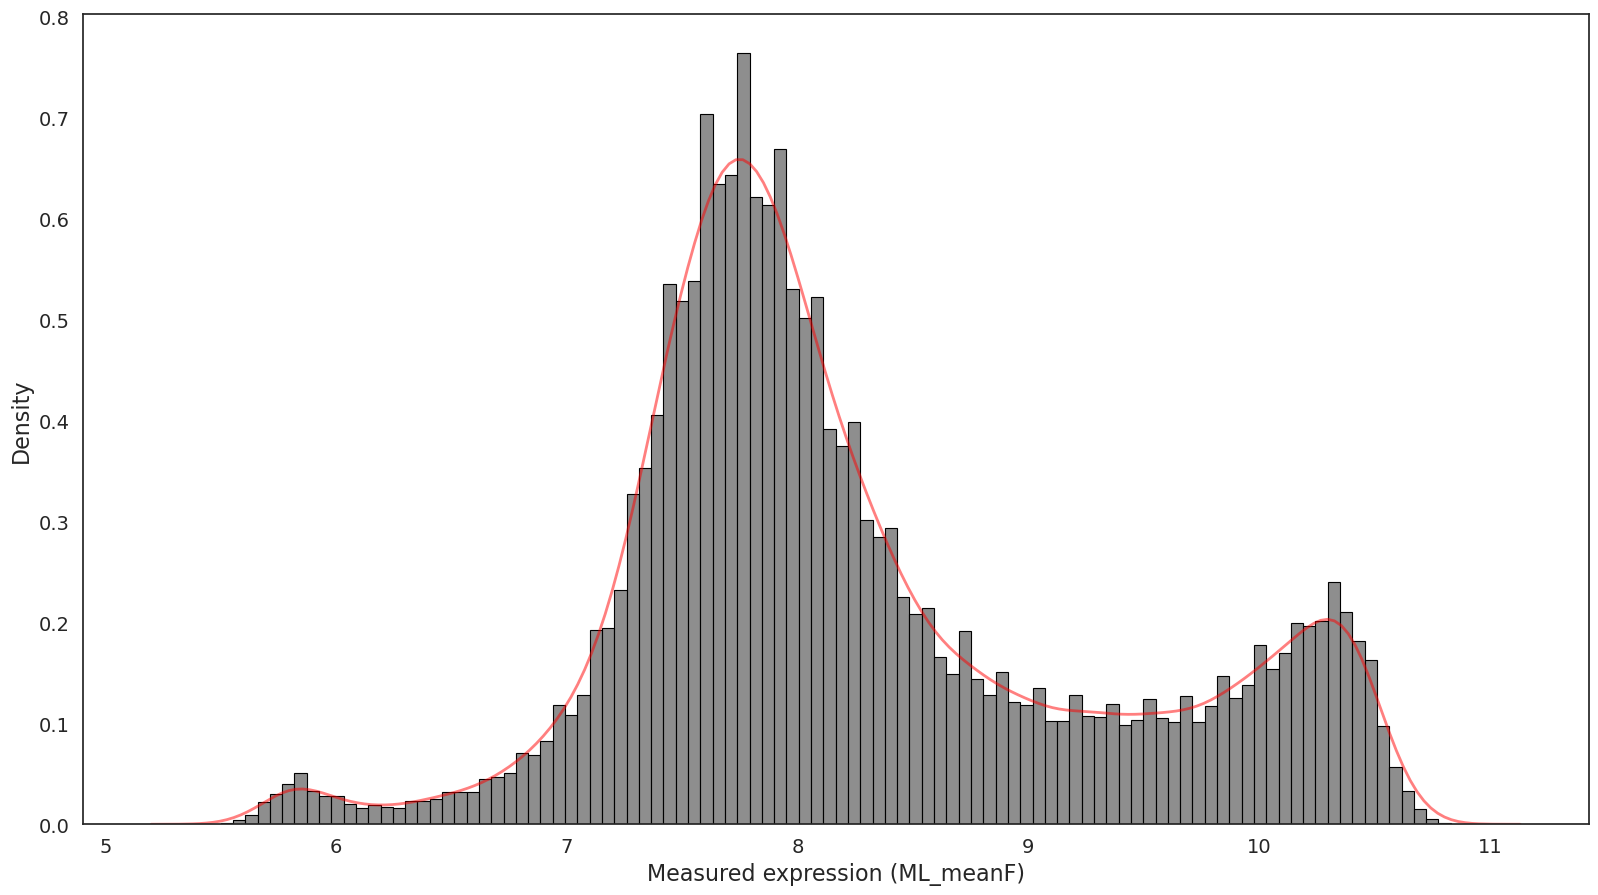

Number of dedup entries that had dups: 10920


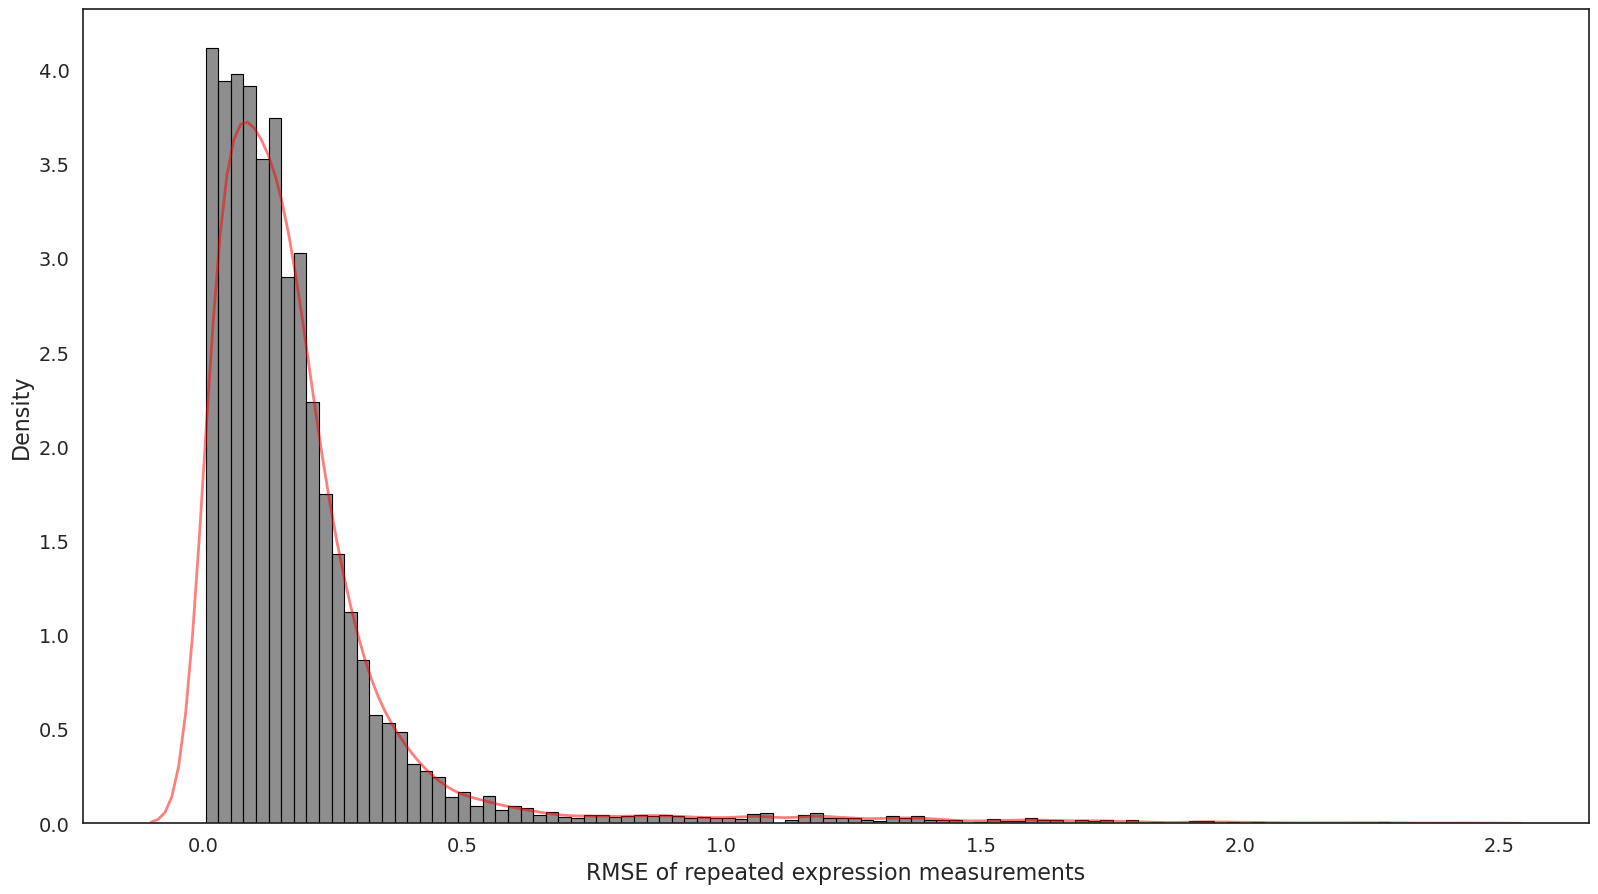

In [162]:
# Drop replicates using sequences
dedup_expression_df = expression_df.drop_duplicates(subset='label', keep='first')
print('Number of dedup entries:', len(dedup_expression_df)) 
plot_value_distribution(dedup_expression_df, "mean_ML_meanF", "Measured expression (ML_meanF)")

# Drop single sequences 
dups_only_expression_df = dedup_expression_df[dedup_expression_df['rmse_expression'] != 0.0]
print('Number of dedup entries that had dups:', len(dups_only_expression_df))
plot_value_distribution(dups_only_expression_df, "rmse_expression", "RMSE of repeated expression measurements")

### Combining into single dataset
Rows that do not have a match in either binding or expression dataframes will be excluded. This is for the combined multi-error esm-blstm model. Some points will be lost!

In [163]:
# Deduped final number:
print(f'binding: {len(dedup_binding_df)}, expression: {len(dedup_expression_df)}')

# Inner join merge
dedup_combined_df = pd.merge(dedup_binding_df, dedup_expression_df, on=['label', 'sequence', 'target'], how='inner')
print(f'merged: {len(dedup_combined_df)}')

# Shouldn't drop any due to inner join, but do it just in case
dedup_combined_df = dedup_combined_df.dropna(subset=['ML_meanF'])
dedup_combined_df = dedup_combined_df.dropna(subset=['log10Ka'])
print(f'after drop na (if any): {len(dedup_combined_df)}')

binding: 105525, expression: 116257
merged: 102723
after drop na (if any): 102723


The numbers (binding: 105,525, expression: 116,257) are correct, so the final merged number should be 102,723.

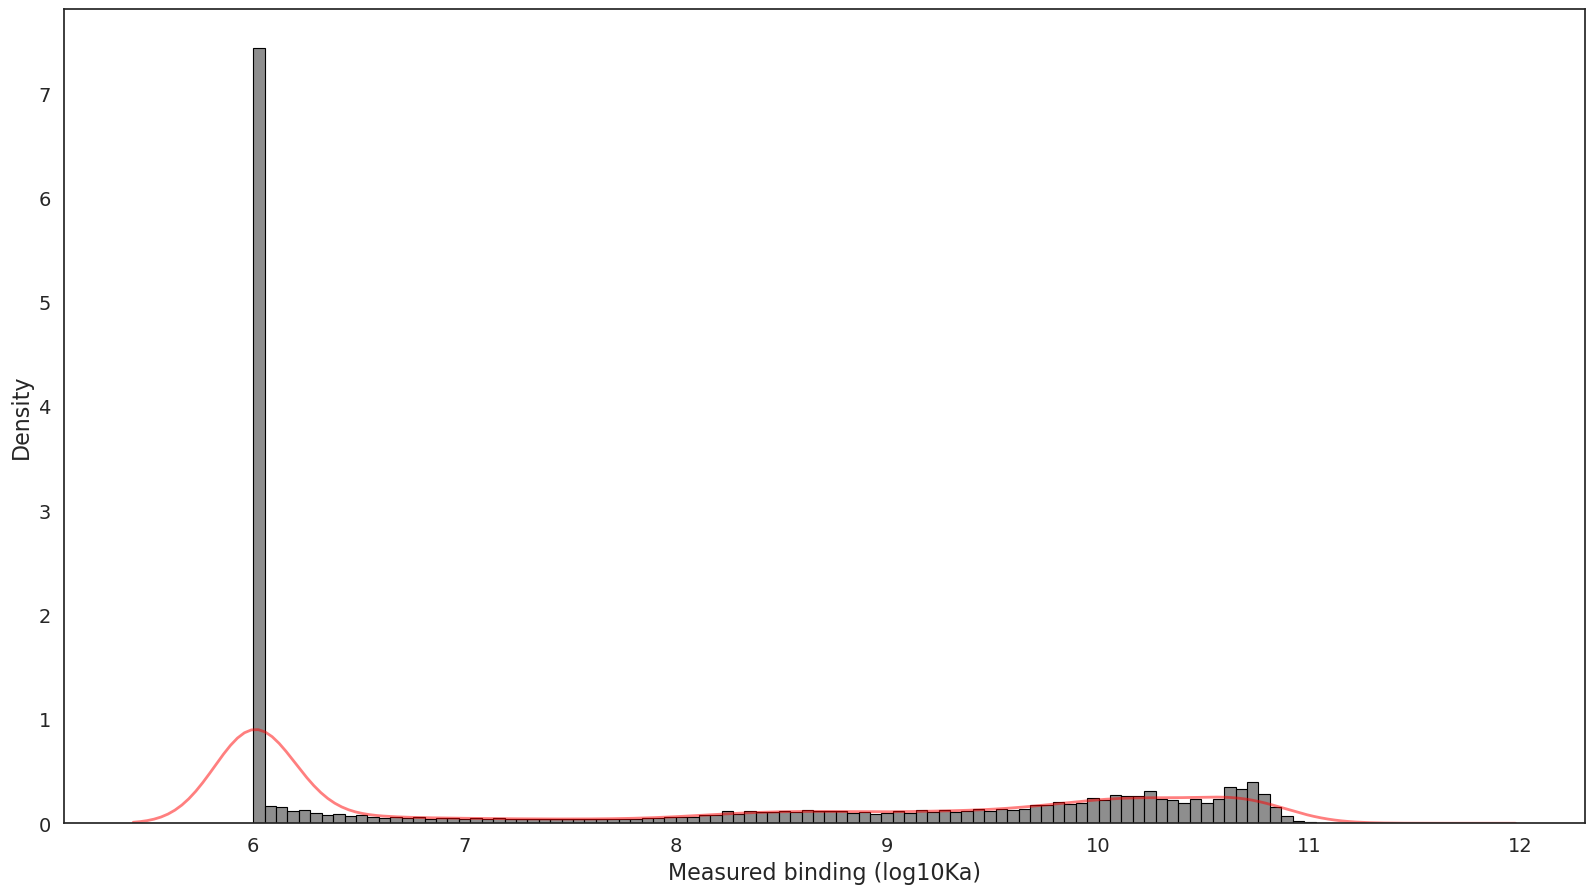

Number of dedup entries that had dups: 7642


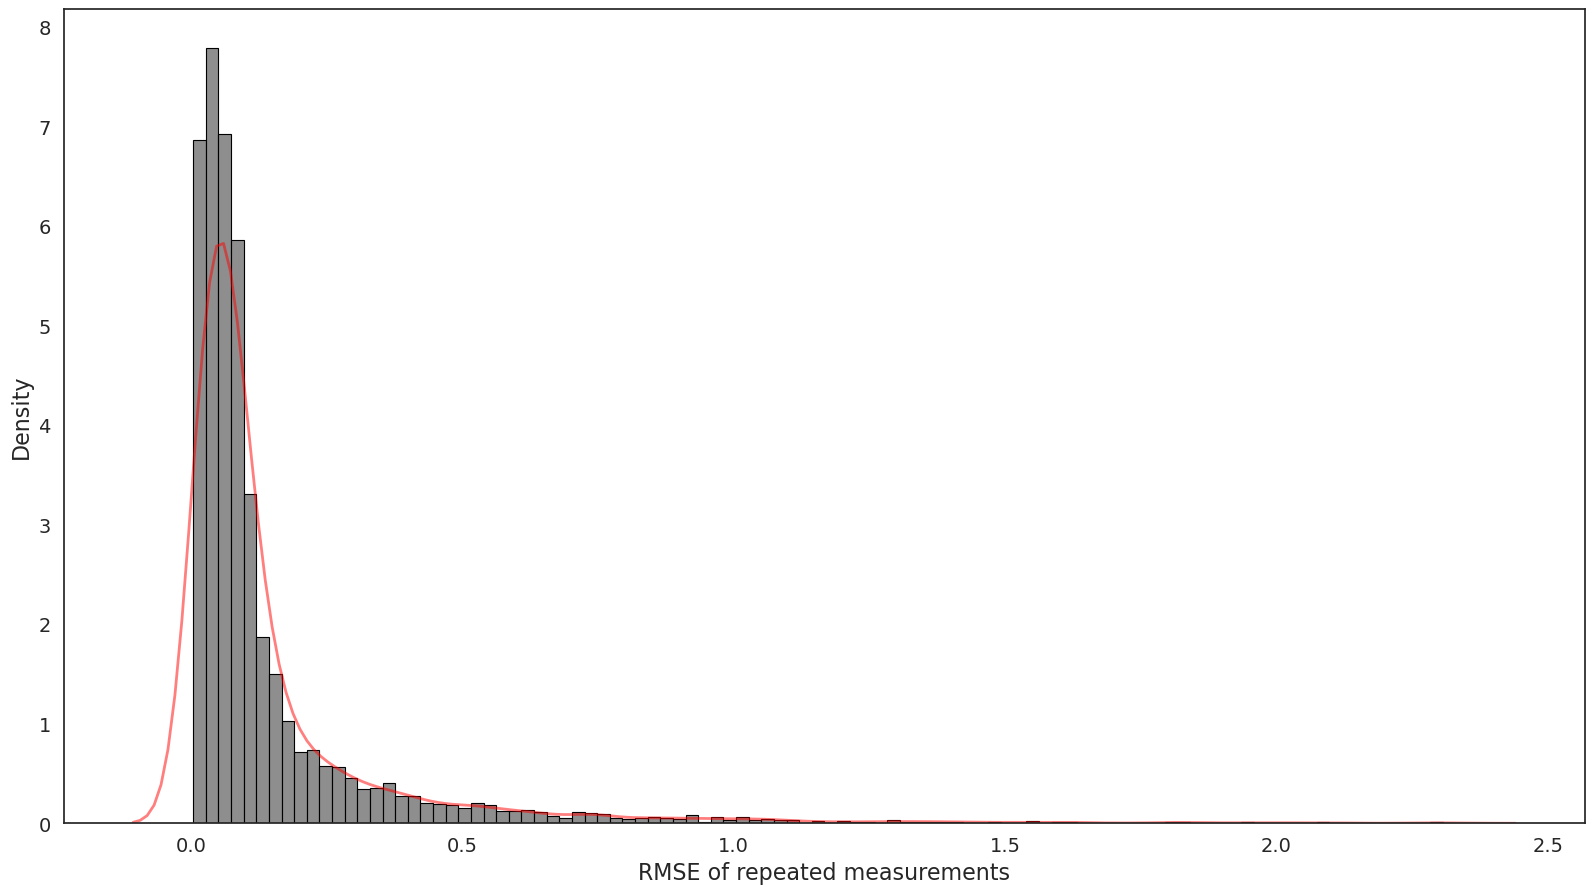

In [164]:
# Binding
plot_value_distribution(dedup_combined_df, "mean_log10Ka", "Measured binding (log10Ka)")

# Drop single sequences 
dups_only_b_combined_df = dedup_combined_df[dedup_combined_df['rmse_binding'] != 0.0]
print('Number of dedup entries that had dups:', len(dups_only_b_combined_df))
plot_value_distribution(dups_only_b_combined_df, "rmse_binding", "RMSE of repeated measurements")

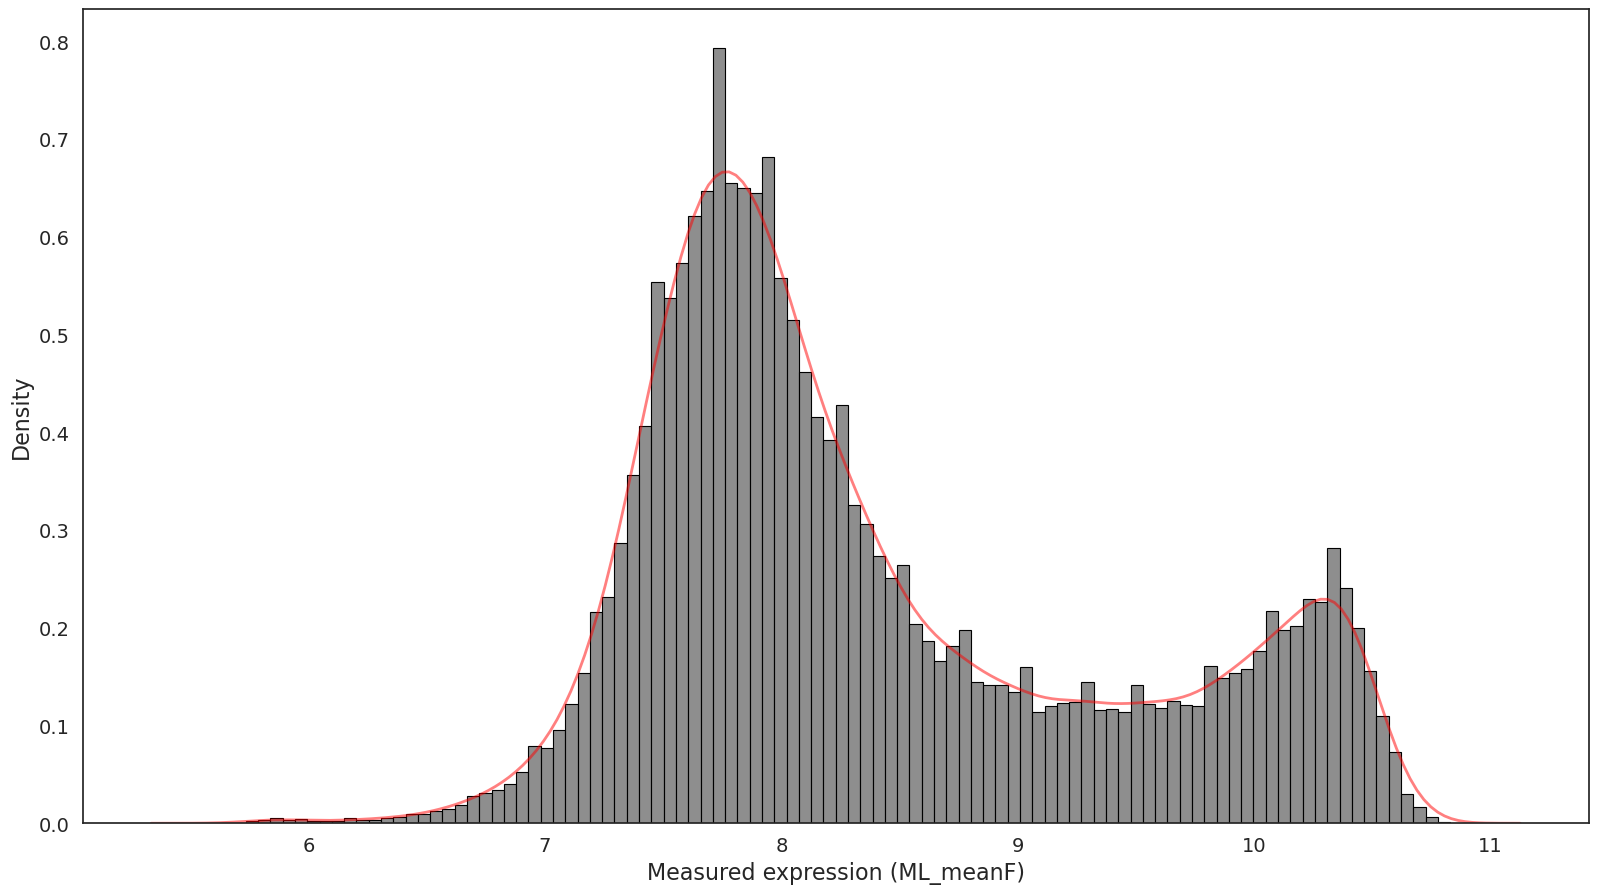

Number of dedup entries that had dups: 10441


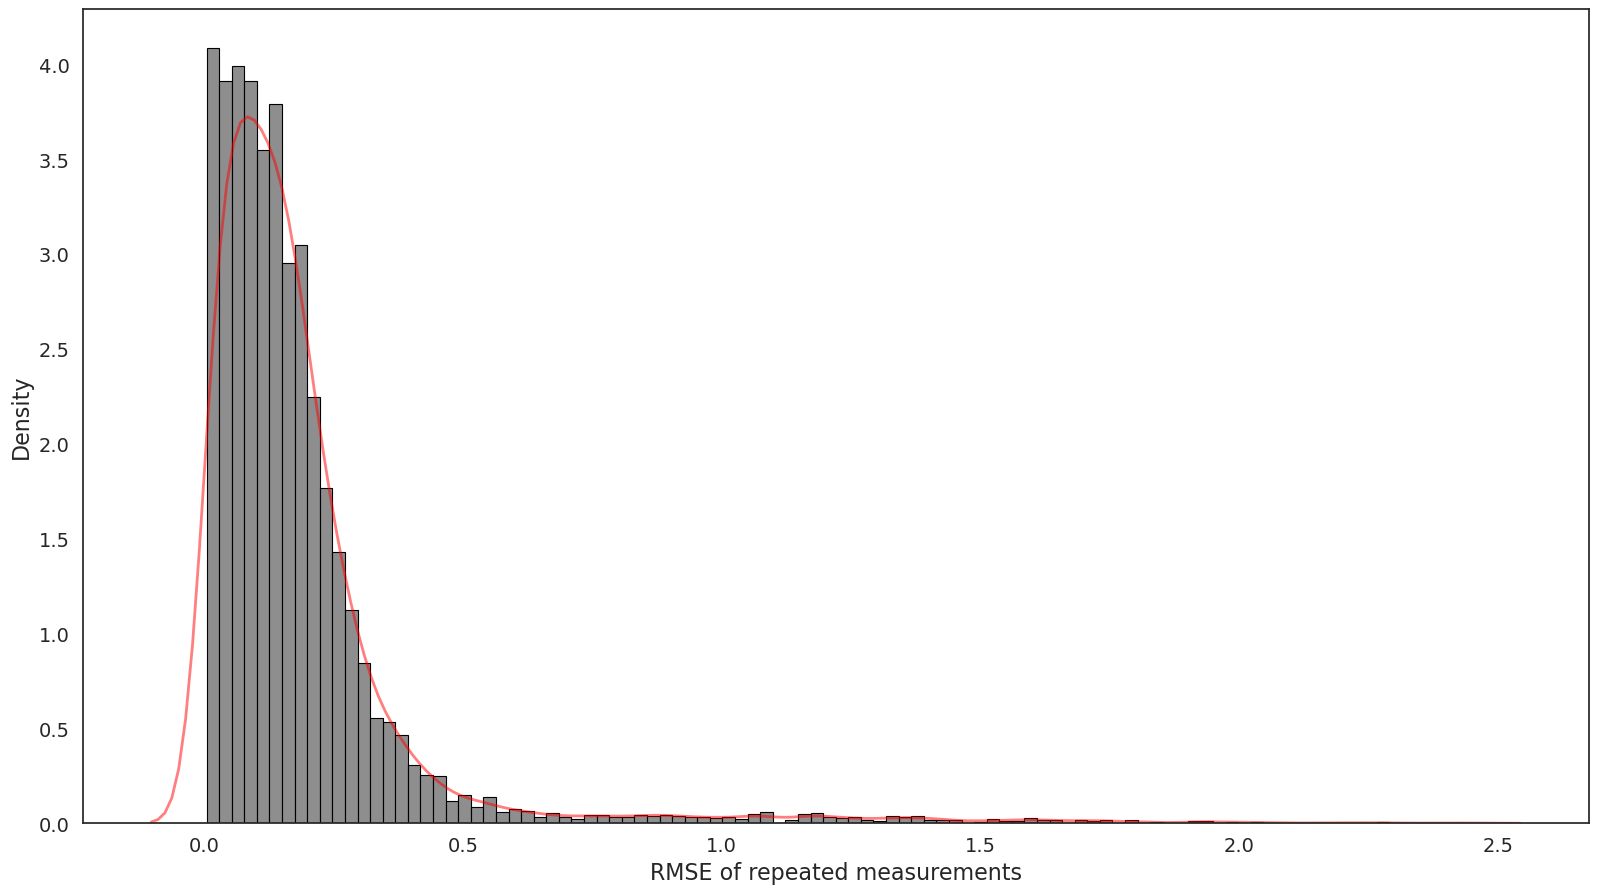

In [165]:
# Expression
plot_value_distribution(dedup_combined_df, "mean_ML_meanF", "Measured expression (ML_meanF)")

# Drop single sequences 
dups_only_e_combined_df = dedup_combined_df[dedup_combined_df['rmse_expression'] != 0.0]
print('Number of dedup entries that had dups:', len(dups_only_e_combined_df))
plot_value_distribution(dups_only_e_combined_df, "rmse_expression", "RMSE of repeated measurements")

Let's save the combined old data and split it:

In [166]:
import csv
import random

def split_csv(rnd_seed: int, input_csv: str, output_csv:str):
    """
    Split csv file into train, test data.
    """
    train_csv = output_csv.replace('.csv', '_train.csv')
    test_csv  = output_csv.replace('.csv', '_test.csv')

    with open(input_csv, "r") as input_file:
        reader = csv.reader(input_file)
        header = next(reader)
        input_records = list(reader)

    random.seed(rnd_seed)
    random.shuffle(input_records)

    split_idx = int(0.8 * len(input_records))
    train_records = input_records[:split_idx]
    test_records = input_records[split_idx:]

    with open(train_csv, 'w') as ft, open(test_csv, 'w') as fv:
        train_writer = csv.writer(ft)
        test_writer = csv.writer(fv)

        train_writer.writerow(header)
        test_writer.writerow(header)

        for record in train_records:
            train_writer.writerow(record)

        for record in test_records:
            test_writer.writerow(record)

    print(f'Total: {len(input_records)}, Train: {len(train_records)}, Test: {len(test_records)}')

# Filter 
filtered_dedup_combined_df = dedup_combined_df[['label','target', 'sequence', 'mean_log10Ka', 'mean_ML_meanF']].copy()
filtered_dedup_combined_df = filtered_dedup_combined_df.rename(columns={
    'mean_log10Ka': 'ACE2-binding_affinity',    # ACE2-binding affinity
    'mean_ML_meanF': 'RBD_expression'           # RBD expression
})

# Save
data_dir = './data'
filtered_dedup_combined_df.to_csv(os.path.join(data_dir, 'processed_dms/mutation_combined_OLD-DMS.csv'), index=False)

# Split to train, test data (80/20)
rnd_seed = 0

mutation_combined_csv = 'mutation_combined_OLD-DMS.csv'
split_csv(
    rnd_seed, 
    os.path.join(data_dir, f'processed_dms/{mutation_combined_csv}'), 
    os.path.join(data_dir, f'split_processed_dms/{mutation_combined_csv}')
)

Total: 102723, Train: 82178, Test: 20545


---
## Newer DMS Data
### Binding

In [167]:
import re
from Bio import SeqIO
from Bio.Seq import Seq

def label_to_seq(row, target_refseqs:dict) -> str:
    """ Generate sequence based on reference sequence and aa_substitutions. """
    aa_substitutions, target = row['aa_substitutions'], row['target']
    refseq = list(target_refseqs[target])
    seq = refseq.copy()
    p = '([0-9]+)'
    
    if '_' in aa_substitutions:
        for mutcode in aa_substitutions.split('_'):
            [ori, pos, mut] = re.split(p, mutcode)
            pos = int(pos)-1    # use 0-based counting
            #assert refseq[pos].upper() == ori, f"At {pos}: {refseq[pos]} != {ori}"
            if refseq[pos].upper() != ori: print(f"{target}, At {pos}: {refseq[pos]} != {ori}")
            seq[pos] = mut.upper()
        seq = ''.join(seq)
        return seq

    if aa_substitutions=='': return ''.join(seq)

    [ori, pos, mut] = re.split(p, aa_substitutions)
    pos = int(pos)-1    # use 0-based counting
    #assert refseq[pos].upper() == ori, f"At {pos}: {refseq[pos]} != {ori}"
    if refseq[pos].upper() != ori: print(f"{target}, At {pos}: {refseq[pos]} != {ori}")
    seq[pos] = mut.upper()
    seq = ''.join(seq)    
    return seq

def extract_refseqs(variants: list) -> dict:
    rename_map = {
    'N501Y': 'Alpha',
    'B1351': 'Beta',
    'Delta': 'Delta',
    'E484K': 'Eta',
    'BA1': 'Omicron_BA1',
    'BA2': 'Omicron_BA2',
    'BQ11': 'Omicron_BQ11',
    'XBB15': 'Omicron_XBB15',
    'Wuhan_Hu_1': 'Wuhan_Hu_1'
    }
    target_dict = {}

    for v in variants:
        amplicon = os.path.join(data_dir, f'../amplicons/PacBio_amplicon_{v}.gb')
        # Extract data from genbank file
        data = SeqIO.read(amplicon, 'genbank')
        # Get full sequence, features 
        full_seq = data.seq
        features = data.features
        # Get locations for the "gene", apply to the full sequence
        for feature in features:
            if feature.type == "gene":
                dna_seq = feature.location.extract(full_seq)
        # Convert DNA to RNA
        rna_seq = dna_seq.transcribe()
        # Translate RNA to Amino Acids
        protein_seq= rna_seq.translate()
        # Get the renamed target from the rename_map, default to the original name if not found
        renamed_target = rename_map.get(v, v)
        # Add to target dictionary with the renamed key
        target_dict[renamed_target] = protein_seq
    
    return target_dict

data_dir = './data/original_dms'

variants = ['Wuhan_Hu_1', 'B1351', 'E484K', 'N501Y', 'Delta', 'BA1', 'BA2', 'BQ11', 'XBB15']
target_refseqs = extract_refseqs(variants)
for t in target_refseqs: print(f"{t}: {target_refseqs[t]}") 

Wuhan_Hu_1: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST
Beta: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST
Eta: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVKGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKST
Alpha: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQPYRVVVLSFELLHAPATVCGPKKST
Delta: NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEG

In [168]:
# Get binding file paths
binding_df_list = []

for file in os.listdir(data_dir):
    if file.endswith('_binding.csv'):
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path, sep=',', header=0)
        print(f'{file}: {len(df)}')
        binding_df_list.append(df)

# Merge all DataFrames into a single DataFrame
merged_df = pd.concat(binding_df_list, ignore_index=True)
row_count = len(merged_df)
print(f'Total rows after merging: {row_count}')

# Rename target columns for easier variant identification
rename_map = {
'N501Y': 'Alpha',
'B1351': 'Beta',
'Delta': 'Delta',
'E484K': 'Eta',
'BA1': 'Omicron_BA1',
'BA2': 'Omicron_BA2',
'BQ11': 'Omicron_BQ11',
'XBB15': 'Omicron_XBB15',
'Wuhan_Hu_1': 'Wuhan_Hu_1'
}
merged_df['target'] = merged_df['target'].replace(rename_map)
print(f"Different variants/targets: {merged_df['target'].unique()}\n")

# Remove rows where specified column is NA
merged_df = merged_df.dropna(subset=['log10Ka']).reset_index(drop=True)
print(f"Number of data points with na: {row_count-len(merged_df)}")
print(f"Number of data points left: {len(merged_df)}\n")

# Filter out variant classes that are not nonsynonymous
nonsynonymous_df = merged_df[merged_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
print(f"Number of datapoints after removal of nonsynonymous variant classes: {len(nonsynonymous_df)}\n")

# Add '_' to aa_substitutions column
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['aa_substitutions'] = nonsynonymous_df['aa_substitutions'].replace(' ', '_', regex=True)
# Apply mutation to reference sequence
nonsynonymous_df['sequence'] = nonsynonymous_df.apply(label_to_seq, axis=1, target_refseqs=target_refseqs)

# Create a new column 'label' using 'target' and 'aa_substitutions' columns
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['label'] = nonsynonymous_df['target'] + '-' + nonsynonymous_df['aa_substitutions']
print(f"{nonsynonymous_df['label'].value_counts()}\n")

# Filter to only the columns we want 
nonsynonymous_df = nonsynonymous_df[['label','target', 'sequence', 'log10Ka']].copy()

# Group by label and calculate mean_log10Ka, mse, and rmse for each group
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['mean_log10Ka'] = nonsynonymous_df.groupby('label')['log10Ka'].transform('mean')
nonsynonymous_df['difference_squared_binding'] = (nonsynonymous_df['log10Ka'] - nonsynonymous_df['mean_log10Ka']) ** 2
nonsynonymous_df['mse_binding'] = nonsynonymous_df.groupby('label')['difference_squared_binding'].transform('mean')
nonsynonymous_df['rmse_binding'] = np.sqrt(nonsynonymous_df['mse_binding'])
print('Number entries w/ rmse calculated:', len(nonsynonymous_df))

# Drop Wuhan entries
nonsynonymous_df = nonsynonymous_df[nonsynonymous_df['target'] != 'Wuhan_Hu_1']
print(f"Number of datapoints after removing Wuhan entries: {len(nonsynonymous_df)}")

binding_df = nonsynonymous_df.copy()
binding_df

delta-bc_binding.csv: 205734
omicron_BA-bc_binding.csv: 649481
omicron_XBB_BQ-bc_binding.csv: 598394
variants-bc_binding.csv: 520339
Total rows after merging: 1973948
Different variants/targets: ['Delta' 'Omicron_BA2' 'Omicron_XBB15' 'Omicron_BQ11' 'Wuhan_Hu_1'
 'Omicron_BA1' 'Alpha' 'Beta' 'Eta']

Number of data points with na: 584370
Number of data points left: 1389578

Number of datapoints after removal of nonsynonymous variant classes: 1208108

label
Eta-V115L                    153
Eta-N171S                    145
Omicron_BA2-I138C            142
Wuhan_Hu_1-V115L             140
Wuhan_Hu_1-K48Q              138
                            ... 
Omicron_BA2-V194C_P197L        1
Omicron_XBB15-N109P_S116F      1
Omicron_XBB15-G152P_G166D      1
Omicron_XBB15-K48R_P96S        1
Alpha-S19D_Y159H               1
Name: count, Length: 112598, dtype: int64

Number entries w/ rmse calculated: 1208108
Number of datapoints after removing Wuhan entries: 1058197


,label,target,sequence,log10Ka,mean_log10Ka,difference_squared_binding,mse_binding,rmse_binding
0,Delta-K48Y,Delta,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.633369,8.705047,0.005138,0.015509,0.124535
1,Delta-G146D,Delta,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.670145,8.588672,0.006638,0.023348,0.152801
3,Delta-Y21F_V181F,Delta,NITNLCPFGEVFNATRFASVFAWNRKRISNCVADYSVLYNSASFST...,6.905148,6.905148,0.000000,0.000000,0.000000
4,Delta-F62L,Delta,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.921607,9.013862,0.008511,0.021552,0.146807
5,Delta-Q176F,Delta,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,5.508447,5.483586,0.000618,0.195315,0.441944
...,...,...,...,...,...,...,...,...
1389568,Alpha-V77K,Alpha,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.860996,8.898543,0.001410,0.189116,0.434874
1389571,Alpha-L57Y_T63I,Alpha,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.876175,8.876175,0.000000,0.000000,0.000000
1389572,Alpha-S19D_Y159H,Alpha,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...,7.927880,7.927880,0.000000,0.000000,0.000000
1389574,Beta-S19T,Beta,NITNLCPFGEVFNATRFATVYAWNRKRISNCVADYSVLYNSASFST...,8.275822,8.299705,0.000570,0.090312,0.300519


Number of dedup entries: 98497


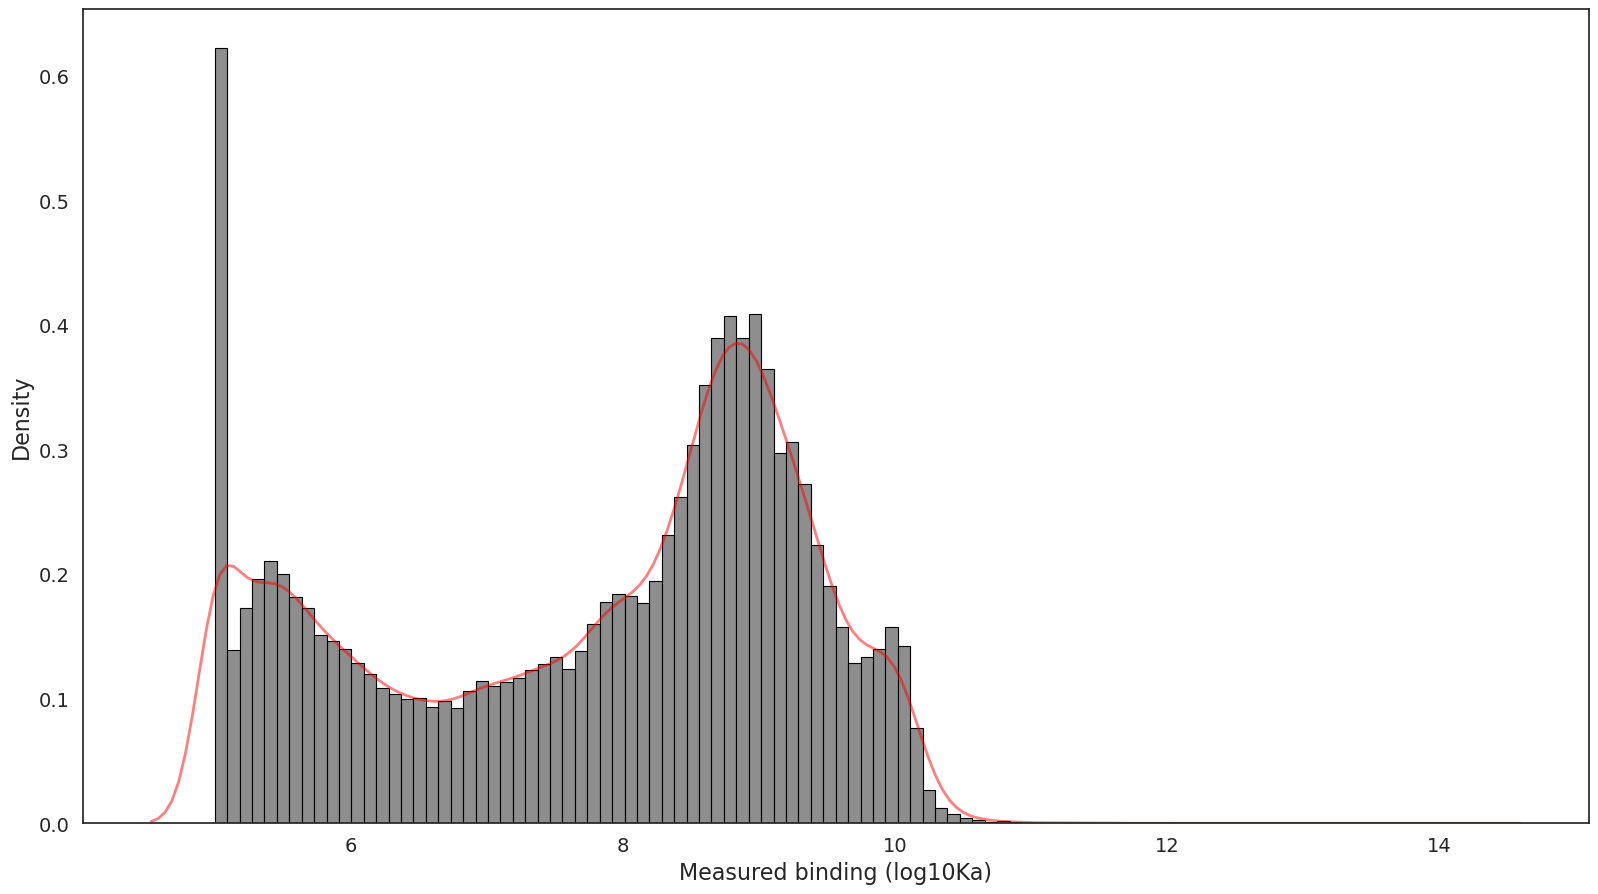

Number of dedup entries that had dups: 50372


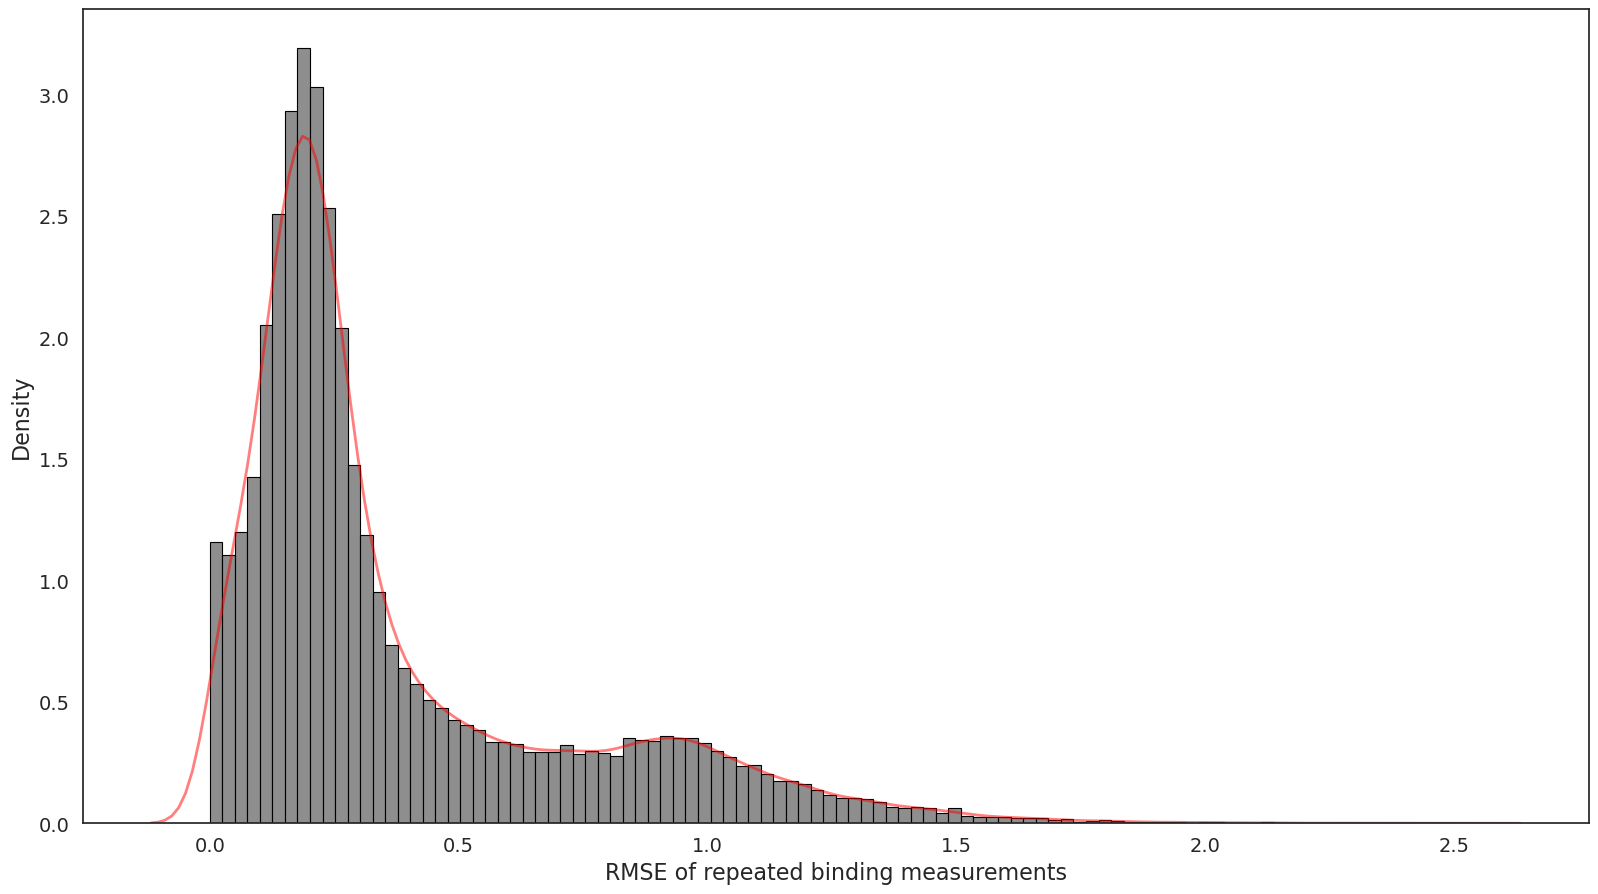

In [169]:
# Drop replicates using sequences
dedup_binding_df = binding_df.drop_duplicates(subset='label', keep='first')
print('Number of dedup entries:', len(dedup_binding_df)) 
plot_value_distribution(dedup_binding_df, "mean_log10Ka", "Measured binding (log10Ka)")

# Drop single sequences 
dups_only_binding_df = dedup_binding_df[dedup_binding_df['rmse_binding'] != 0.0]
print('Number of dedup entries that had dups:', len(dups_only_binding_df))
plot_value_distribution(dups_only_binding_df, "rmse_binding", "RMSE of repeated binding measurements")

### Expression

In [170]:
# Get expression file paths
expression_df_list = []

for file in os.listdir(data_dir):
    if file.endswith('_expression.csv'):
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path, sep=',', header=0)
        print(f'{file}: {len(df)}')
        expression_df_list.append(df)

# Merge all DataFrames into a single DataFrame
merged_df = pd.concat(expression_df_list, ignore_index=True)
row_count = len(merged_df)
print(f'Total rows after merging: {row_count}')

# Rename target columns for easier variant identification
rename_map = {
'N501Y': 'Alpha',
'B1351': 'Beta',
'Delta': 'Delta',
'E484K': 'Eta',
'BA1': 'Omicron_BA1',
'BA2': 'Omicron_BA2',
'BQ11': 'Omicron_BQ11',
'XBB15': 'Omicron_XBB15',
'Wuhan_Hu_1': 'Wuhan_Hu_1'
}
merged_df['target'] = merged_df['target'].replace(rename_map)
print(f"Different variants/targets: {merged_df['target'].unique()}\n")

# Remove rows where specified column is NA
merged_df = merged_df.dropna(subset=['expression']).reset_index(drop=True)
print(f"Number of data points with na: {row_count-len(merged_df)}")
print(f"Number of data points left: {len(merged_df)}\n")

# Filter out variant classes that are not nonsynonymous
nonsynonymous_df = merged_df[merged_df['variant_class'].str.contains('nonsynonymous', case=False, na=False)]
print(f"Number of datapoints after removal of nonsynonymous variant classes: {len(nonsynonymous_df)}\n")

# Add '_' to aa_substitutions column
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['aa_substitutions'] = nonsynonymous_df['aa_substitutions'].replace(' ', '_', regex=True)
# Apply mutation to reference sequence
nonsynonymous_df['sequence'] = nonsynonymous_df.apply(label_to_seq, axis=1, target_refseqs=target_refseqs)

# Create a new column 'label' using 'target' and 'aa_substitutions' columns
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['label'] = nonsynonymous_df['target'] + '-' + nonsynonymous_df['aa_substitutions']
print(f"{nonsynonymous_df['label'].value_counts()}\n")

# Filter to only the columns we want 
nonsynonymous_df = nonsynonymous_df[['label','target', 'sequence', 'expression']].copy()

# Group by label and calculate mean_expression, mse, and rmse for each group
nonsynonymous_df = nonsynonymous_df.copy()
nonsynonymous_df['mean_expression'] = nonsynonymous_df.groupby('label')['expression'].transform('mean')
nonsynonymous_df['difference_squared_expression'] = (nonsynonymous_df['expression'] - nonsynonymous_df['mean_expression']) ** 2
nonsynonymous_df['mse_expression'] = nonsynonymous_df.groupby('label')['difference_squared_expression'].transform('mean')
nonsynonymous_df['rmse_expression'] = np.sqrt(nonsynonymous_df['mse_expression'])
print('Number entries w/ rmse calculated:', len(nonsynonymous_df))

# Drop Wuhan entries
nonsynonymous_df = nonsynonymous_df[nonsynonymous_df['target'] != 'Wuhan_Hu_1']
print(f"Number of datapoints after removing Wuhan entries: {len(nonsynonymous_df)}")

expression_df = nonsynonymous_df.copy()
expression_df

delta-bc_expression.csv: 205734
omicron_BA-bc_expression.csv: 598394
omicron_XBB_BQ-bc_expression.csv: 649481
variants-bc_expression.csv: 337629
Total rows after merging: 1791238
Different variants/targets: ['Delta' 'Omicron_BA2' 'Wuhan_Hu_1' 'Omicron_BA1' 'Omicron_XBB15'
 'Omicron_BQ11' 'Alpha' 'Beta' 'Eta']

Number of data points with na: 396749
Number of data points left: 1394489

Number of datapoints after removal of nonsynonymous variant classes: 1230966

label
Omicron_BA2-V115G          162
Omicron_BA2-I138N          153
Omicron_BA2-G172C          151
Omicron_BA2-P133V          151
Omicron_BA2-P177W          150
                          ... 
Wuhan_Hu_1-V52A_Y165K        1
Omicron_BA1-D9L_G174V        1
Wuhan_Hu_1-N30I_G174K        1
Omicron_BA1-I104A_G174V      1
Alpha-P54D_L183H             1
Name: count, Length: 118245, dtype: int64

Number entries w/ rmse calculated: 1230966
Number of datapoints after removing Wuhan entries: 1114971


,label,target,sequence,expression,mean_expression,difference_squared_expression,mse_expression,rmse_expression
0,Delta-K48Y,Delta,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,9.422970,9.266909,0.024355,0.235287,0.485063
1,Delta-G146D,Delta,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,9.683871,9.644749,0.001531,0.163401,0.404228
3,Delta-Y21F_V181F,Delta,NITNLCPFGEVFNATRFASVFAWNRKRISNCVADYSVLYNSASFST...,6.771556,6.771556,0.000000,0.000000,0.000000
4,Delta-F62L,Delta,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,9.818137,9.676914,0.019944,0.176336,0.419924
5,Delta-Q176F,Delta,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,8.170880,8.074020,0.009382,0.138161,0.371700
...,...,...,...,...,...,...,...,...
1394481,Alpha-L57Y_T63I,Alpha,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,7.934413,7.934413,0.000000,0.000000,0.000000
1394482,Alpha-S19D_Y159H,Alpha,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...,9.508858,9.508858,0.000000,0.000000,0.000000
1394484,Beta-S19T,Beta,NITNLCPFGEVFNATRFATVYAWNRKRISNCVADYSVLYNSASFST...,7.639761,7.297956,0.116831,0.086172,0.293550
1394487,Alpha-P54D_L183H,Alpha,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,6.388546,6.388546,0.000000,0.000000,0.000000


Number of dedup entries: 104101


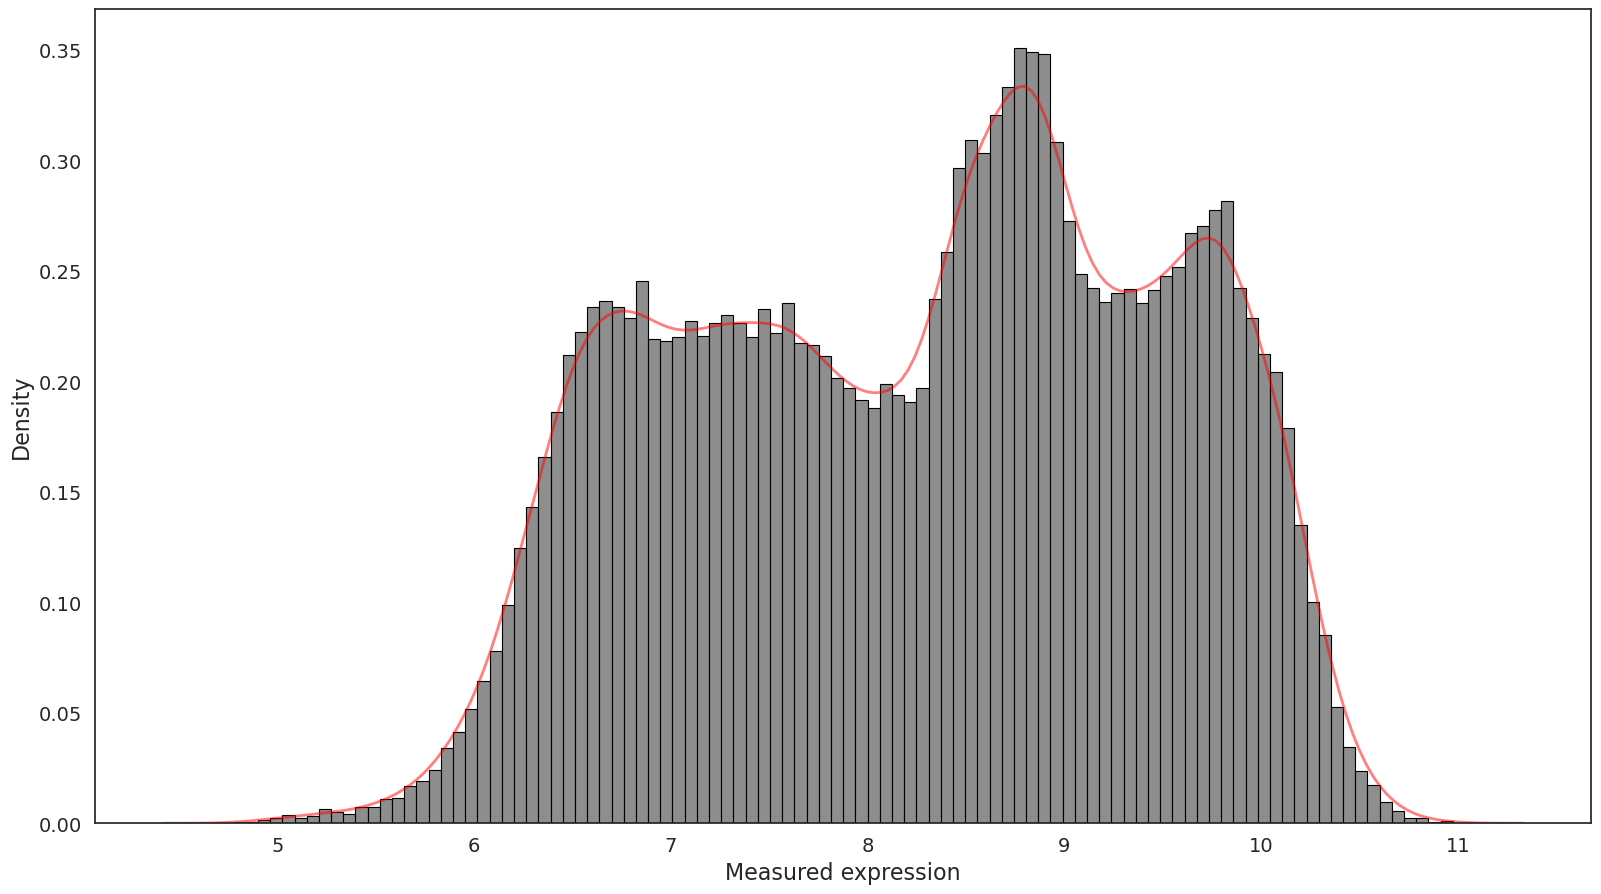

Number of dedup entries that had dups: 38564


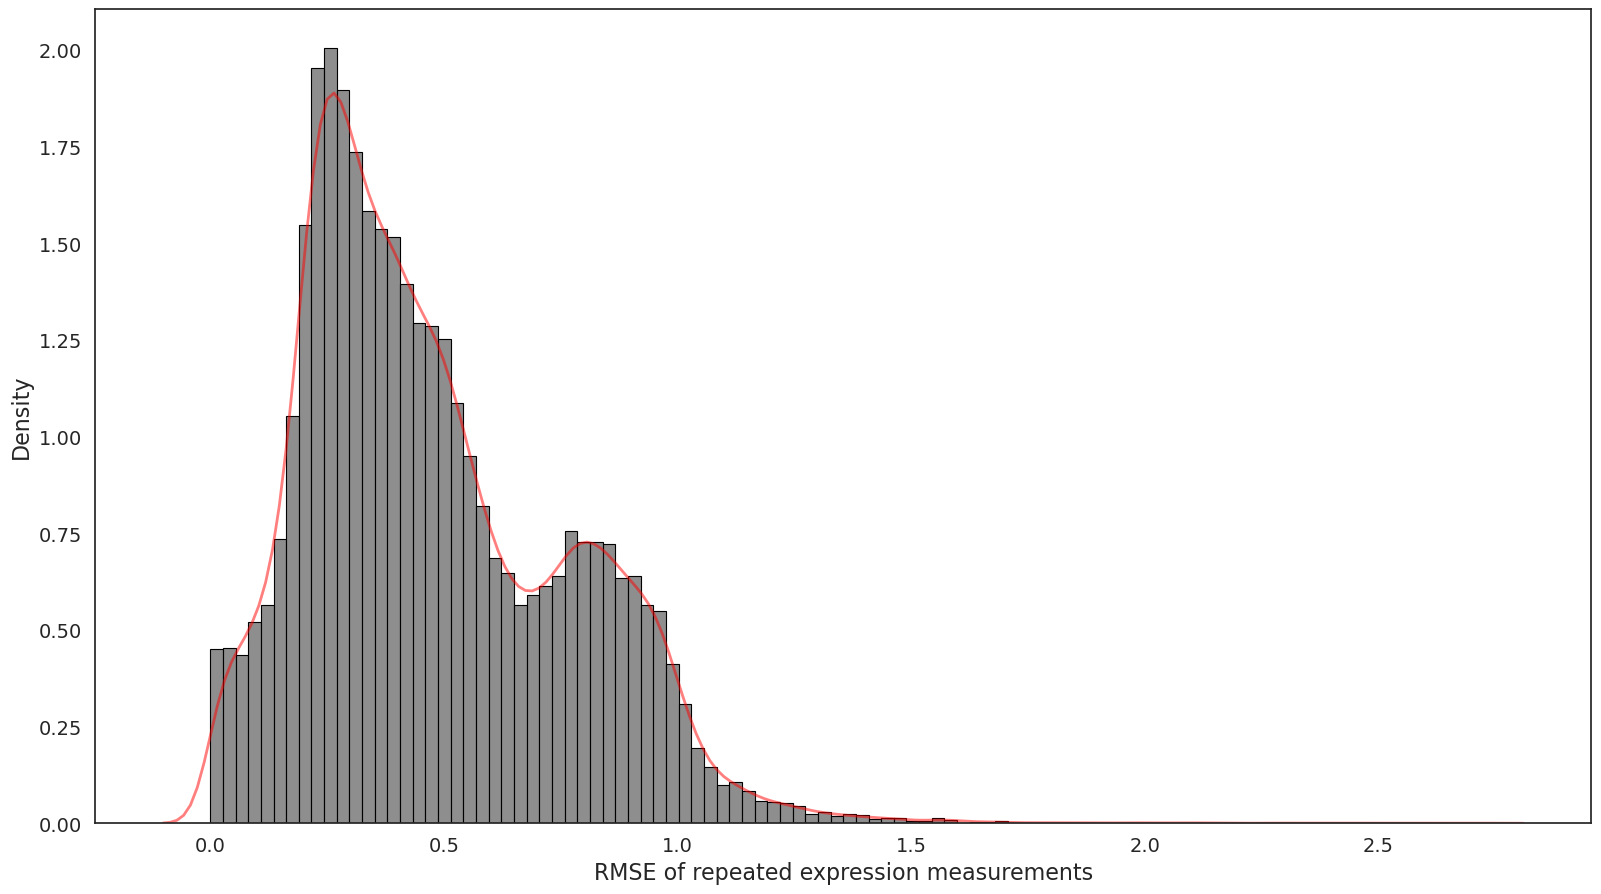

In [171]:
# Drop replicates using sequences
dedup_expression_df = expression_df.drop_duplicates(subset='label', keep='first')
print('Number of dedup entries:', len(dedup_expression_df)) 
plot_value_distribution(dedup_expression_df, "mean_expression", "Measured expression")

# Drop single sequences 
dups_only_expression_df = dedup_expression_df[dedup_expression_df['rmse_expression'] != 0.0]
print('Number of dedup entries that had dups:', len(dups_only_expression_df))
plot_value_distribution(dups_only_expression_df, "rmse_expression", "RMSE of repeated expression measurements")

### Combining into single dataset
Some points will be lost!

In [172]:
# Deduped final number:
print(f'binding: {len(dedup_binding_df)}, expression: {len(dedup_expression_df)}')

# Inner join merge
dedup_combined_df = pd.merge(dedup_binding_df, dedup_expression_df,  on=['label', 'sequence', 'target'], how='inner')
print(f'merged: {len(dedup_combined_df)}')

# Shouldn't drop any due to inner join, but do it just in case
dedup_combined_df = dedup_combined_df.dropna(subset=['expression'])
dedup_combined_df = dedup_combined_df.dropna(subset=['log10Ka'])
print(f'after drop na (if any): {len(dedup_combined_df)}')

binding: 98497, expression: 104101
merged: 97249
after drop na (if any): 97249


97249 is the same number of rows after cleaning and combining the data in `new_dms_data_processing.ipynb`, so that is good!

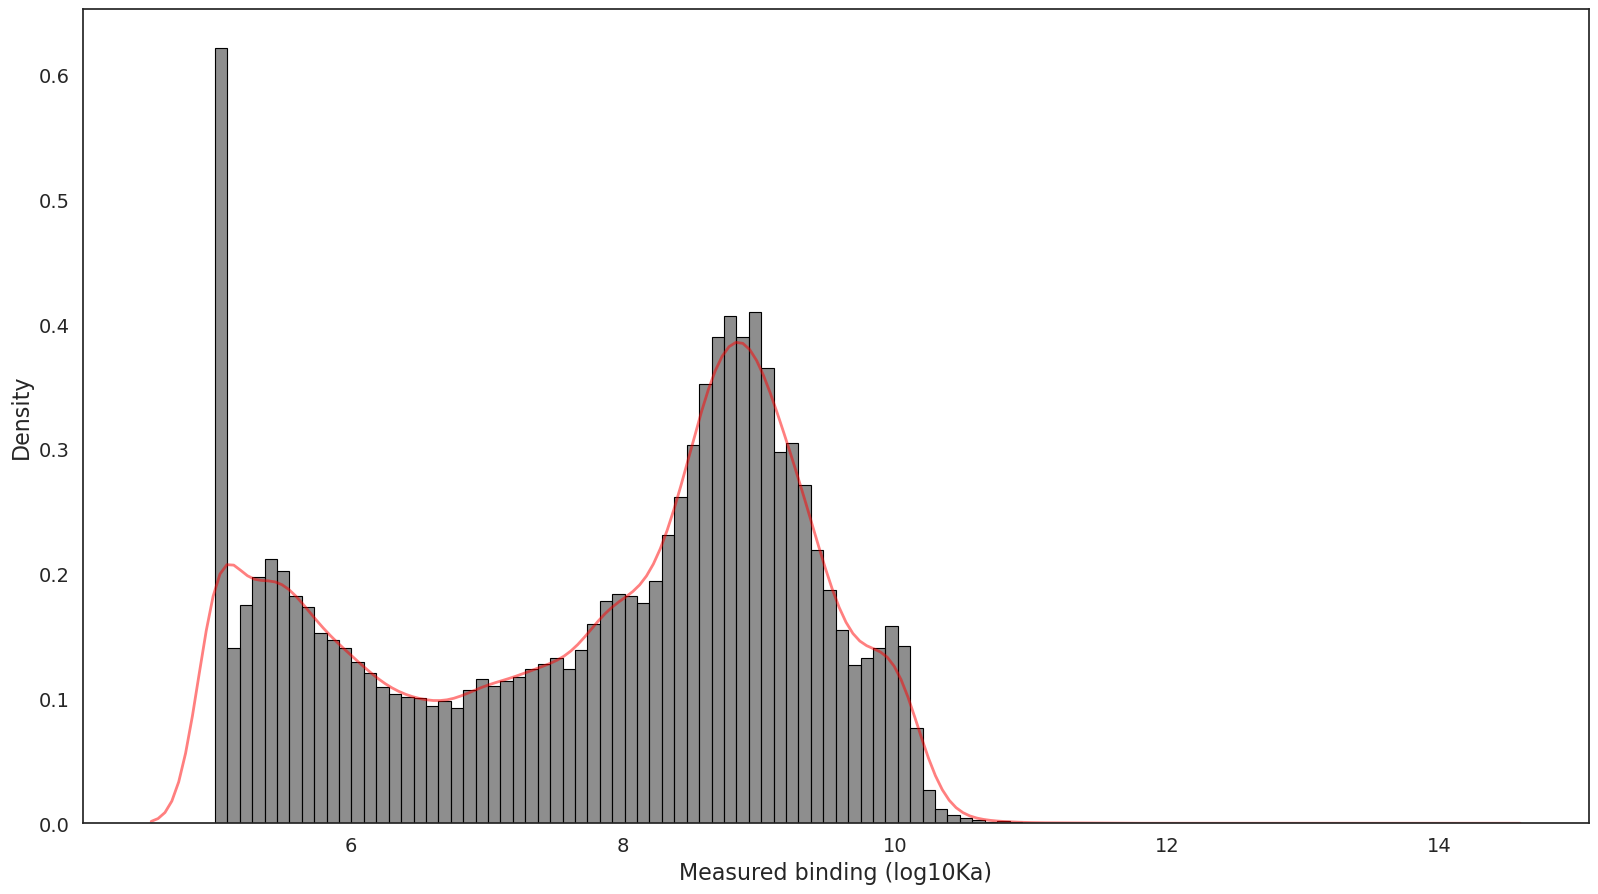

Number of dedup entries that had dups: 50164


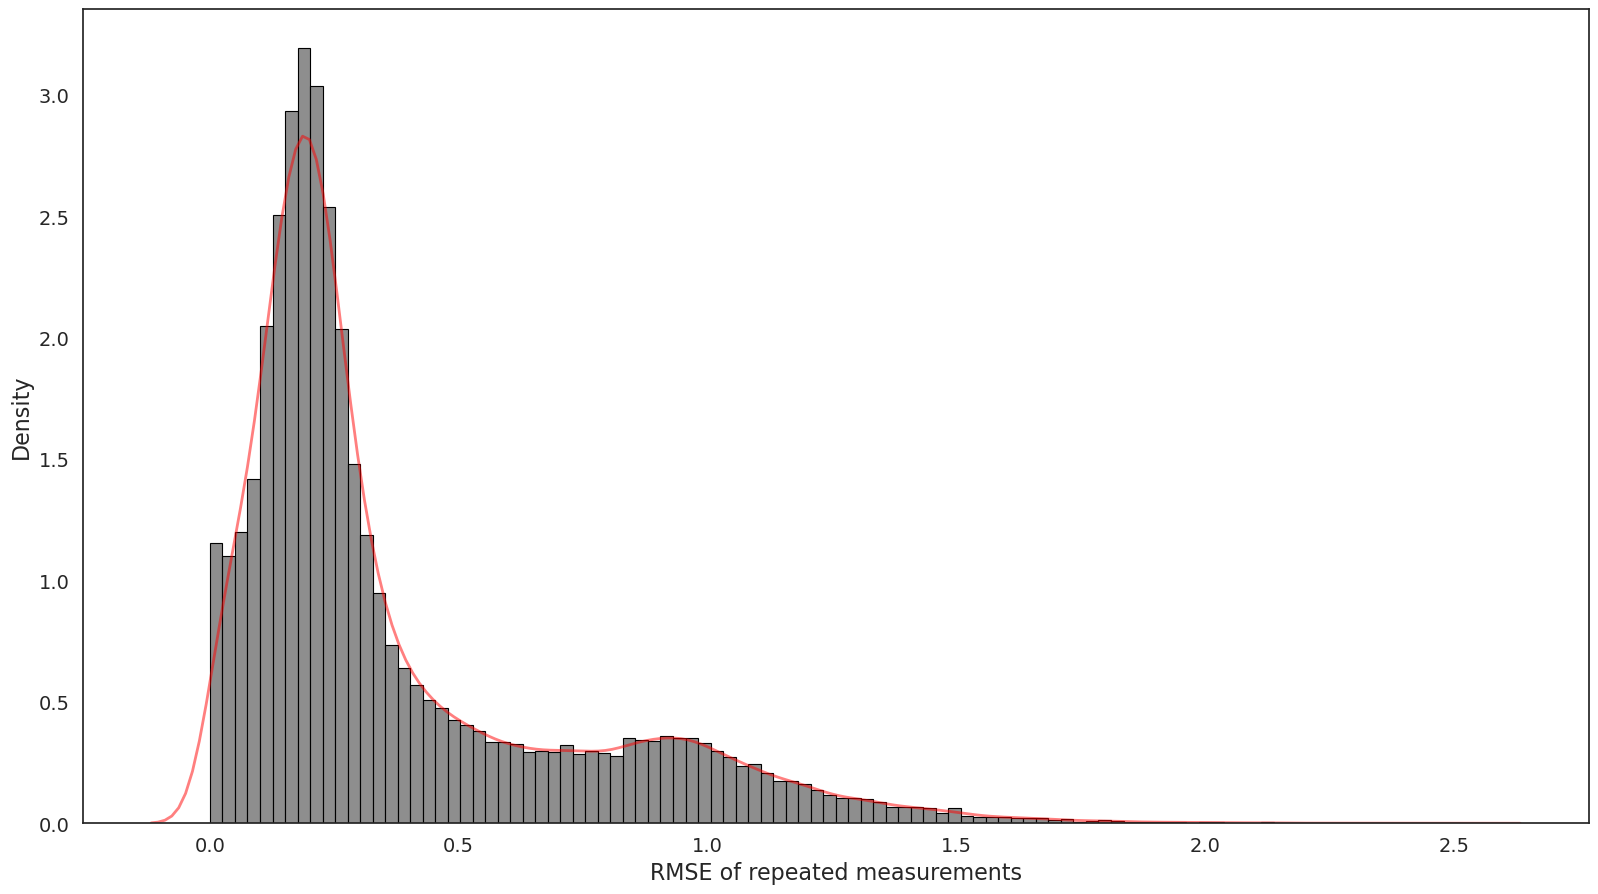

In [173]:
# Binding
plot_value_distribution(dedup_combined_df, "mean_log10Ka", "Measured binding (log10Ka)")

# Drop single sequences 
dups_only_b_combined_df = dedup_combined_df[dedup_combined_df['rmse_binding'] != 0.0]
print('Number of dedup entries that had dups:', len(dups_only_b_combined_df))
plot_value_distribution(dups_only_b_combined_df, "rmse_binding", "RMSE of repeated measurements")

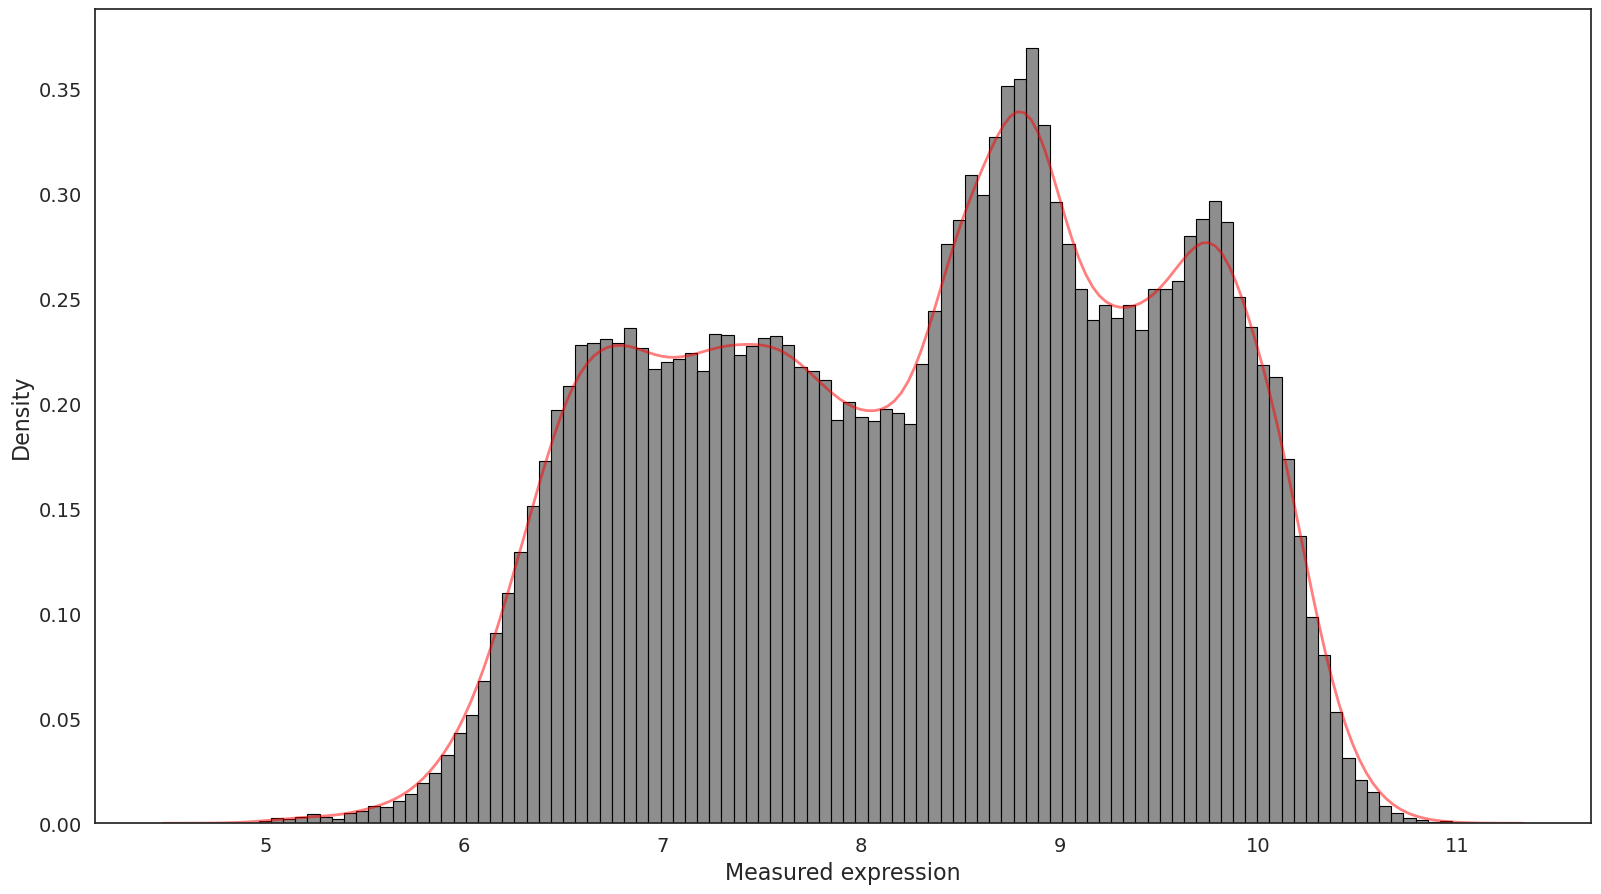

Number of dedup entries that had dups: 38152


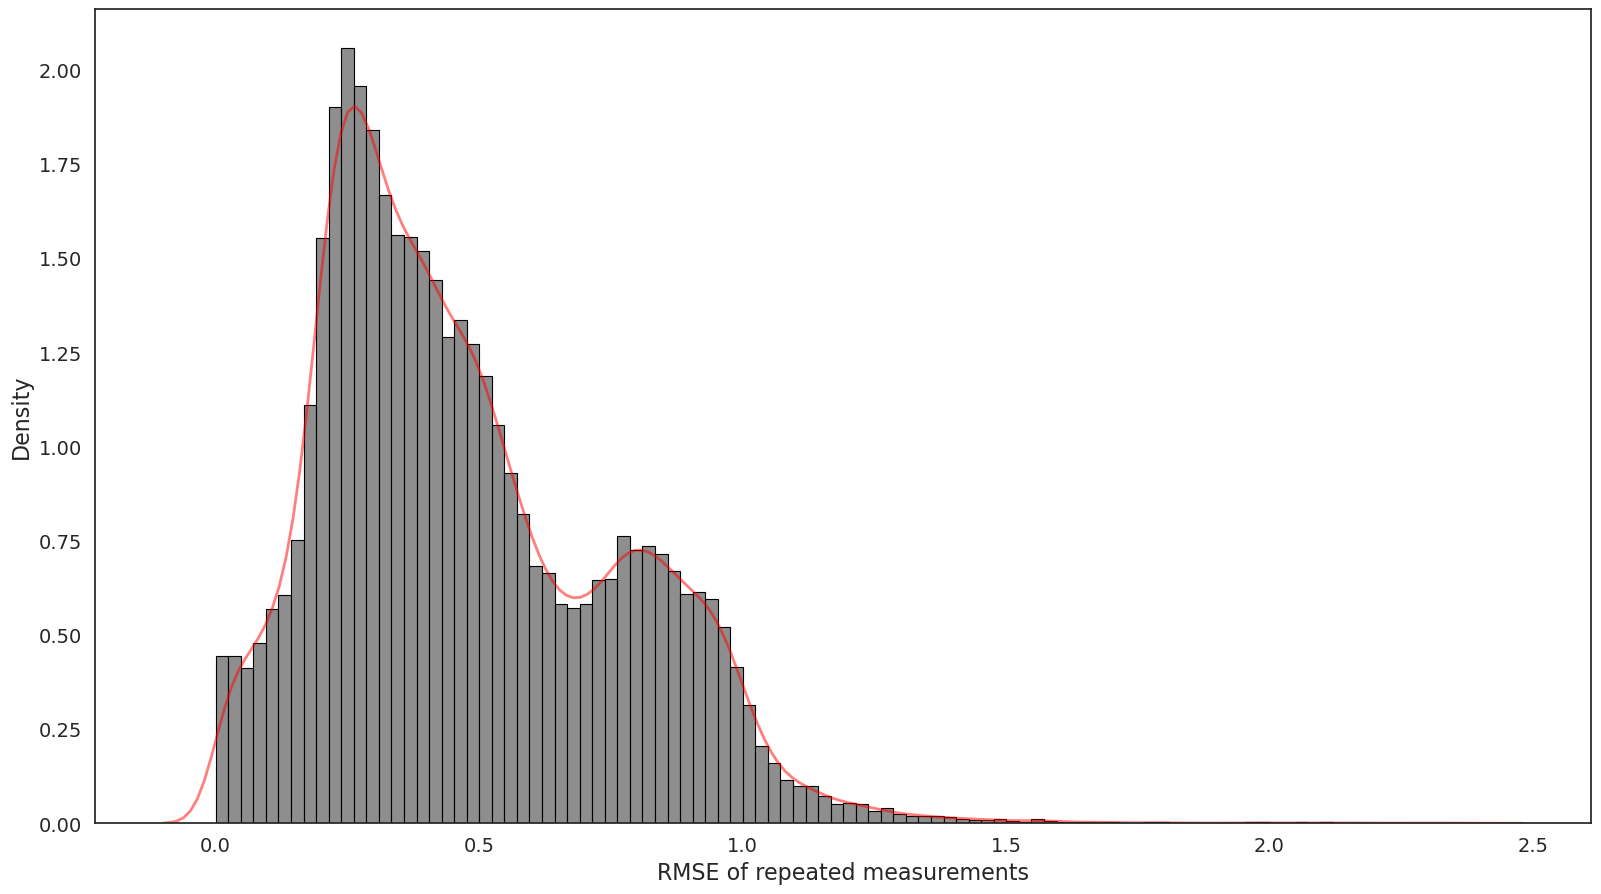

In [174]:
# Expression
plot_value_distribution(dedup_combined_df, "mean_expression", "Measured expression")

# Drop single sequences 
dups_only_e_combined_df = dedup_combined_df[dedup_combined_df['rmse_expression'] != 0.0]
print('Number of dedup entries that had dups:', len(dups_only_e_combined_df))
plot_value_distribution(dups_only_e_combined_df, "rmse_expression", "RMSE of repeated measurements")

Saving and splitting:

In [175]:
# Filter 
filtered_dedup_combined_df = dedup_combined_df[['label','target', 'sequence', 'mean_log10Ka', 'mean_expression']].copy()
filtered_dedup_combined_df = filtered_dedup_combined_df.rename(columns={
    'mean_log10Ka': 'ACE2-binding_affinity',    # ACE2-binding affinity
    'mean_expression': 'RBD_expression'         # RBD expression
})

# Save
data_dir = './data'
filtered_dedup_combined_df.to_csv(os.path.join(data_dir, 'processed_dms/mutation_combined_NEW-DMS.csv'), index=False)

# Split to train, test data (80/20)
rnd_seed = 0

mutation_combined_csv = 'mutation_combined_NEW-DMS.csv'
split_csv(
    rnd_seed, 
    os.path.join(data_dir, f'processed_dms/{mutation_combined_csv}'), 
    os.path.join(data_dir, f'split_processed_dms/{mutation_combined_csv}')
)

Total: 97249, Train: 77799, Test: 19450
